In [4]:
from scipy.io import netcdf
import numpy as np
from pylab import clf, plot, show, floor, ceil, imshow
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
#xlabel, ylabel, legend, savefig, colorbar, title, clim, pcolor, cm, contourf
import os
import csv
import sys
import glob
from netCDF4 import Dataset

from IPython.display import display, Math, Latex, Image
from mpl_toolkits.basemap import Basemap
import mpl_toolkits
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.append('/noc/users/am8e13/PyNGL-1.4.0/lib/python2.7/site-packages/PyNGL/')
import Ngl
sys.path.append('/noc/users/am8e13/Python/')
import komod
sys.path.append('/noc/users/am8e13/Python/PyNIO-1.4.0/')
import Nio

sys.path.append('/noc/users/am8e13/Python/')
from python_functions import *
import cmocean
import random
import calendar

from IPython.html.widgets import interact, interactive
from IPython.display import clear_output, display, HTML

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [5]:
woa = Woa()
#grid = grid_read(36)
grid = grid_read(18)

/noc/users/am8e13/anaconda/lib/python2.7/site-packages/scipy/io/netcdf.py:287: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)
/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [6]:
def fluxesCalculation2(run):
    kdic = {36:1,18:2,9:4}
    kk = kdic[run.res]

    file2read = netcdf.NetCDFFile('/scratch/general/am8e13/results'+str(run.res)+'km/grid.nc','r')
    hfacc = file2read.variables['HFacC']
    hfacc = hfacc[:]*1
    drf = file2read.variables['drF']
    drf = drf[:]*1
    rA = file2read.variables['rA']
    rA = rA[:]*1
    dyF = file2read.variables['dyF']
    dyF = dyF[:]*1
    dxF = file2read.variables['dxF']
    dxF = dxF[:]*1
    dydx = np.zeros_like(hfacc)
    for k in range(len(drf)):
        dydx[k,:,:] = drf[k]*rA*hfacc[k,:,:]
    Area_x = dydx/dxF
    Area_y = dydx/dyF
    Area_x[hfacc==0]=np.nan
    Area_y[hfacc==0]=np.nan
    
    coords = {}
    coords = {'Fram': [58,80,76,76], 'Fram1' : [55,85,78,78] , 'Fram2' : [60,83,72,72] , 'Denmark': [100,100,37,48] , \
             'Bering' : [80,89,178,178] , 'Davis' : [113,135,75,75] , 'Davis1' : [135,135,52,73] , 'Davis2' : [113,135,75,75]}
    ax_d = {'Fram': 3, 'Fram1' : 3 , 'Fram2' : 3 , 'Denmark': 2 , 'Bering' : 3 , 'Davis' : 3 , 'Davis1' : 2 , 'Davis2' : 3}
    vel = {'Fram': 'U', 'Fram1' : 'V' , 'Fram2' : 'V' , 'Denmark': 'U' , \
             'Bering' : 'V' , 'Davis' : 'U' , 'Davis1' : 'U' , 'Davis2' : 'U' }
    
    def coord_calc(coord):
        if coord[0] == coord[1]:
            coord[0] = coord[0]*kk
            coord[1] = coord[0]+1
            coord[2] = coord[2]*kk
            coord[3] = coord[3]*kk
        elif coord[2] == coord[3]:
            coord[0] = coord[0]*kk
            coord[1] = coord[1]*kk
            coord[2] = coord[2]*kk
            coord[3] = coord[2]+1
        return coord

    run.fluxes2 = {}
    for var in ['Fram','Fram1','Fram2','Denmark','Bering','Davis','Davis1','Davis2']:
        coord = coords[var]
        coord = coord_calc(coord)
        run.fluxes2[var] = {'Flux' : np.zeros_like(run.data[vel[var]][:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSum' : np.zeros_like(run.data[vel[var]][:,0,0,0]),\
                            'FluxInSum' : np.zeros_like(run.data[vel[var]][:,0,0,0]),\
                            'FluxOutSum' : np.zeros_like(run.data[vel[var]][:,0,0,0]),\
                            'FluxS' : np.zeros_like(run.data['S'][:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumS' : np.zeros_like(run.data['S'][:,0,0,0]),\
                            'FluxT' : np.zeros_like(run.data['T'][:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumT' : np.zeros_like(run.data['T'][:,0,0,0]),\
                            'FluxFW' : np.zeros_like(run.data['T'][:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumFW' : np.zeros_like(run.data['T'][:,0,0,0]),\
                            'FluxFW1' : np.zeros_like(run.data['T'][:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumFW1' : np.zeros_like(run.data['T'][:,0,0,0]),\
                            'FluxOverFlow' : np.zeros_like(run.data['T'][:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumOverFlow' : np.zeros_like(run.data['T'][:,0,0,0]),\
                            'FluxTop' : [], 'FluxMid' : [] , 'FluxBot' : [], \
                            'FluxTopS' : [], 'FluxMidS' : [] , 'FluxBotS' : [], \
                            'FluxTopT' : [], 'FluxMidT' : [] , 'FluxBotT' : []}
        
    S0 = 34.8 # reference salinity
    rho0 = 1027.8
    # this is to calculate the FW flux correctly
    tmp = np.ones_like(run.data['S'])
    tmp[:,31:,:,:] = 0
    tmpof = np.zeros_like(run.data['S'])
    tmpof[run.data['rhop']>rho0] = 1

    # this is to calculate the FW flux correctly
    tmp1 = np.ones_like(run.data['S'])
    tmp1[run.data['S']>S0] = 0
    for var in ['Fram','Fram1','Fram2','Denmark','Bering','Davis','Davis1','Davis2']:
        coord = coords[var]
        coord = coord_calc(coord)
        for t in range(run.data['V'].shape[0]):    
            # Fram fillign
            run.fluxes2[var]['Flux'][t,:,:] = run.data[vel[var]][t,:,coord[0]:coord[1],coord[2]:coord[3]]*\
                    Area_y[:,coord[0]:coord[1],coord[2]:coord[3]]/10**6
            run.fluxes2[var]['FluxSum'][t] = np.nansum(np.nansum(run.fluxes2[var]['Flux'][t,:,:]))
            run.fluxes2[var]['FluxInSum'][t] = np.nansum(np.nansum(run.fluxes2[var]['Flux'][t,run.fluxes2[var]['Flux'][t,:,:]>0]))
            run.fluxes2[var]['FluxOutSum'][t] = np.nansum(np.nansum(run.fluxes2[var]['Flux'][t,run.fluxes2[var]['Flux'][t,:,:]<0]))
            run.fluxes2[var]['FluxT'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*\
                                                run.data['T'][t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumT'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxT'][t,:,:]))
            run.fluxes2[var]['FluxS'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*\
                                                run.data['S'][t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumS'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxS'][t,:,:])) 
            run.fluxes2[var]['FluxFW'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*\
                    (1 - run.data['S'][t,:,coord[0]:coord[1],coord[2]:coord[3]]/S0)*tmp[t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumFW'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxFW'][t,:,:]))                 
            run.fluxes2[var]['FluxFW1'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*\
                    (1 - run.data['S'][t,:,coord[0]:coord[1],coord[2]:coord[3]]/S0)*tmp1[t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumFW1'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxFW1'][t,:,:]))   
            run.fluxes2[var]['FluxOverFlow'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*tmpof[t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumOverFlow'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxOverFlow'][t,:,:]))  
            
        for flux in ['Flux','FluxT','FluxS','FluxFW','FluxFW1','FluxOverFlow']:
            run.fluxes2[var][flux] = np.squeeze(run.fluxes2[var][flux],axis=ax_d[var])

In [7]:
#clear_memory(run)
def clear_memory(run):
    del run.data['S'] ,run.data['T'], run.data['V'] , run.data['U'] , run.data['rhop']
    del run.data['rho'] ,run.data['rho_jmd']
    del run.freshwater_content, run.freshwater_content1, run.heat_content
    del run.S, run.T, run.V, run.U
    del run.psi, run.mxldepth
    del run.hfacs, run.hfacw, run.hfacc
    del run.rho, run.rhop, run.rho_jmd
    print 'Memory cleared'

In [71]:
del pert_120_18.rho_jmd, pert_120_18.rho

In [8]:
times = range(0,60,1)+range(61,61+60,1)
pert_bench_18 = RunRead()
pert_bench_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_bench/results/')
pert_bench_18.title('No restoring','blue')
pert_bench_18.readStateData(times)
pert_bench_18.readMonitorData([6220800,6480000])
pert_bench_18.readMonitorSeaiceData([6220800,6480000])
pert_bench_18.readDynStData(11,[6220800,6480000])
#pert_bench_18.readTracers(range(0,75,12))
#pert_bench_18.readLayers(range(0,75,12))
pert_bench_18.seaiceread(range(0,75,1))
pert_bench_18.mxldepthread(range(0,120*3,1))
pert_bench_18.fluxCalc()
pert_bench_18.baroCalc()
pert_bench_18.saveflux('exp_benchmark')
pert_bench_18.savepsi('exp_benchmark')
#pert_bench.read_flux('exp_benchmark')
#pert_bench.read_psi('exp_benchmark')
#pert_bench.readDynStDiagLayers([6220800,6480000])
#pert_bench.readDynStDiagPtracers([6220800,6480000])

freshwater_content(pert_bench_18)
density_calc(pert_bench_18)
fluxesCalculation2(pert_bench_18)
clear_memory(pert_bench_18)

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_bench/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice

/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:319: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:220: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)



Read Mxldepth
Memory cleared


In [9]:
times = range(0,60,1)+range(61,61+60,1)
pert_const_18 = RunRead()
pert_const_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_const/results/')
pert_const_18.readStateData(times)
pert_const_18.title('Const restoring','red')
pert_const_18.readMonitorData([6220800,6480000])
pert_const_18.readMonitorSeaiceData([6220800,6480000])
pert_const_18.readDynStData(11,[6220800,6480000])
#pert_const_18.readTracers(range(0,75,12))
#pert_const_18.readLayers(range(0,75,12))
pert_const_18.seaiceread(range(0,75,1))
pert_const_18.mxldepthread(range(0,120*3,1))
pert_const_18.fluxCalc()
pert_const_18.baroCalc()
pert_const_18.saveflux('exp_contsalt')
pert_const_18.savepsi('exp_contsalt')
#pert_const.read_flux('exp_contsalt')
#pert_const.read_psi('exp_contsalt')
#pert_const.readDynStDiagLayers([6220800,6480000])
#pert_const.readDynStDiagPtracers([6220800,6480000])

freshwater_content(pert_const_18)
density_calc(pert_const_18)
fluxesCalculation2(pert_const_18)
clear_memory(pert_const_18)

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_const/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth
Memory cleared


In [10]:
times = range(0,60,1)+range(61,61+12,1)+range(74,74+48,1)
pert_1y_18 = RunRead()
pert_1y_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_1y/results/')
pert_1y_18.readStateData(times)
pert_1y_18.title('Const restoring','red')
pert_1y_18.readMonitorData([6220800,6480000,6531840])
pert_1y_18.readMonitorSeaiceData([6220800,6480000,6531840])
pert_1y_18.readDynStData(11,[6220800,6480000,6531840])
#pert_const_18.readTracers(range(0,75,12))
#pert_const_18.readLayers(range(0,75,12))
pert_1y_18.seaiceread(range(0,75,1))
pert_1y_18.mxldepthread(range(0,120*3,1))
pert_1y_18.fluxCalc()
pert_1y_18.baroCalc()
pert_1y_18.saveflux('exp_contsalt')
pert_1y_18.savepsi('exp_contsalt')
#pert_const.read_flux('exp_contsalt')
#pert_const.read_psi('exp_contsalt')
#pert_const.readDynStDiagLayers([6220800,6480000])
#pert_const.readDynStDiagPtracers([6220800,6480000])

freshwater_content(pert_1y_18)
density_calc(pert_1y_18)
fluxesCalculation2(pert_1y_18)
clear_memory(pert_1y_18)

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_1y/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth
Memory cleared


In [11]:
times = range(0,60,1)+range(61,61+12,1)+range(74,74+48,1)
pert_1y_rest_18 = RunRead()
pert_1y_rest_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_1y_rest/results/')
pert_1y_rest_18.readStateData(times)
pert_1y_rest_18.title('Const restoring','red')
pert_1y_rest_18.readMonitorData([6220800,6480000,6531840])
pert_1y_rest_18.readMonitorSeaiceData([6220800,6480000,6531840])
pert_1y_rest_18.readDynStData(11,[6220800,6480000,6531840])
#pert_const_18.readTracers(range(0,75,12))
#pert_const_18.readLayers(range(0,75,12))
pert_1y_rest_18.seaiceread(range(0,75,1))
pert_1y_rest_18.mxldepthread(range(0,120*3,1))
pert_1y_rest_18.fluxCalc()
pert_1y_rest_18.baroCalc()
pert_1y_rest_18.saveflux('exp_contsalt')
pert_1y_rest_18.savepsi('exp_contsalt')
#pert_const.read_flux('exp_contsalt')
#pert_const.read_psi('exp_contsalt')
#pert_const.readDynStDiagLayers([6220800,6480000])
#pert_const.readDynStDiagPtracers([6220800,6480000])

freshwater_content(pert_1y_rest_18)
density_calc(pert_1y_rest_18)
fluxesCalculation2(pert_1y_rest_18)
clear_memory(pert_1y_rest_18)

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_1y_rest/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth
Memory cleared


In [12]:
times = range(0,60,1)+range(61,61+60,1)
pert_40_18 = RunRead()
pert_40_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_40_const/results/')
pert_40_18.readStateData(times)
pert_40_18.title('Const restoring','red')
pert_40_18.readMonitorData([6220800,6480000])
pert_40_18.readMonitorSeaiceData([6220800,6480000])
pert_40_18.readDynStData(11,[6220800,6480000])
pert_40_18.seaiceread(range(0,75,1))
pert_40_18.mxldepthread(range(0,120*3,1))
pert_40_18.fluxCalc()
pert_40_18.baroCalc()

freshwater_content(pert_40_18)
density_calc(pert_40_18)
fluxesCalculation2(pert_40_18)
clear_memory(pert_40_18)

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_40_const/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth
Memory cleared


In [13]:
times = range(0,60,1)+range(61,61+60,1)
pert_50_18 = RunRead()
pert_50_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_50_const/results/')
pert_50_18.readStateData(times)
pert_50_18.title('Const restoring','red')
pert_50_18.readMonitorData([6220800,6480000])
pert_50_18.readMonitorSeaiceData([6220800,6480000])
pert_50_18.readDynStData(11,[6220800,6480000])
pert_50_18.seaiceread(range(0,75,1))
pert_50_18.mxldepthread(range(0,120*3,1))
pert_50_18.fluxCalc()
pert_50_18.baroCalc()

freshwater_content(pert_50_18)
density_calc(pert_50_18)
fluxesCalculation2(pert_50_18)
clear_memory(pert_50_18)

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_50_const/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth
Memory cleared


In [14]:
times = range(0,60,1)+range(61,61+60,1)
pert_70_18 = RunRead()
pert_70_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_70_const/results/')
pert_70_18.readStateData(times)
pert_70_18.title('Const restoring','red')
pert_70_18.readMonitorData([6220800,6480000])
pert_70_18.readMonitorSeaiceData([6220800,6480000])
pert_70_18.readDynStData(11,[6220800,6480000])
pert_70_18.seaiceread(range(0,75,1))
pert_70_18.mxldepthread(range(0,120*3,1))
pert_70_18.fluxCalc()
pert_70_18.baroCalc()

freshwater_content(pert_70_18)
density_calc(pert_70_18)
fluxesCalculation2(pert_70_18)
clear_memory(pert_70_18)

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_70_const/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth
Memory cleared


In [15]:
times = range(0,60,1)+range(61,61+36,1)+range(98,98 + 24,1)
pert_120_18 = RunRead()
pert_120_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_120_const/results/')
pert_120_18.readStateData(times)
pert_120_18.title('Const restoring','red')
pert_120_18.readMonitorData([6220800,6531840,6842880])
pert_120_18.readMonitorSeaiceData([6220800,6531840,6842880])
pert_120_18.readDynStData(11,[6220800,6531840,6842880])
pert_120_18.seaiceread(range(0,75,1))
pert_120_18.mxldepthread(range(0,120*3,1))
pert_120_18.fluxCalc()
pert_120_18.baroCalc()

freshwater_content(pert_120_18)
density_calc(pert_120_18)
fluxesCalculation2(pert_120_18)
clear_memory(pert_120_18)

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_120_const/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth
Memory cleared


In [16]:
times = range(0,60,1)+range(61,61+60,1)
pert_small_18 = RunRead()
pert_small_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_small/results/')
pert_small_18.readStateData(times)
pert_small_18.title('Const restoring','red')
pert_small_18.readMonitorData([6220800,6480000])
pert_small_18.readMonitorSeaiceData([6220800,6480000])
pert_small_18.readDynStData(11,[6220800,6480000])
pert_small_18.seaiceread(range(0,75,1))
pert_small_18.mxldepthread(range(0,120*3,1))
pert_small_18.fluxCalc()
pert_small_18.baroCalc()

freshwater_content(pert_small_18)
density_calc(pert_small_18)
fluxesCalculation2(pert_small_18)
clear_memory(pert_small_18)

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_small/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth
Memory cleared


In [17]:
times = range(0,60,1)+range(61,61+36,1)+range(98,98+24,1)
pert_big_18 = RunRead()
pert_big_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_big/results/')
pert_big_18.readStateData(times)
pert_big_18.title('Const restoring','red')
pert_big_18.readMonitorData([6220800,6531840,6842880])
pert_big_18.readMonitorSeaiceData([6220800,6531840,6842880])
pert_big_18.readDynStData(11,[6220800,6531840,6842880])
pert_big_18.seaiceread(range(0,75,1))
pert_big_18.mxldepthread(range(0,120*3,1))
pert_big_18.fluxCalc()
pert_big_18.baroCalc()

freshwater_content(pert_big_18)
density_calc(pert_big_18)
fluxesCalculation2(pert_big_18)
clear_memory(pert_big_18)

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_big/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth
Memory cleared


In [18]:
times = range(0,60,1)+range(61,61+24,1)+range(86,86+24,1)+range(110,110+12,1)
pert_short_18 = RunRead()
pert_short_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_short/results/')
pert_short_18.readStateData(times)
pert_short_18.title('Const restoring','red')
pert_short_18.readMonitorData([6220800,6480000,6583680,6687360])
pert_short_18.readMonitorSeaiceData([6220800,6480000,6583680,6687360])
pert_short_18.readDynStData(11,[6220800,6480000,6583680,6687360])
pert_short_18.seaiceread(range(0,75,1))
pert_short_18.mxldepthread(range(0,120*3,1))
pert_short_18.fluxCalc()
pert_short_18.baroCalc()

freshwater_content(pert_short_18)
density_calc(pert_short_18)
fluxesCalculation2(pert_short_18)
clear_memory(pert_short_18)

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_short/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth
Memory cleared


In [19]:
times = range(0,60,1)+range(61,61+12,1)+range(74,74+12,1)+range(87,87+12,1)+range(100,100+12,1)+range(113,113+12,1)
pert_tall_18 = RunRead()
pert_tall_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_tall/results/')
pert_tall_18.readStateData(times)
pert_tall_18.title('Const restoring','red')
pert_tall_18.readMonitorData([6220800,6531840,6635520,6739200,6842880,6946560])
pert_tall_18.readMonitorSeaiceData([6220800,6531840,6635520,6739200,6842880,6946560])
pert_tall_18.readDynStData(11,[6220800,6531840,6635520,6739200,6842880,6946560])
pert_tall_18.seaiceread(range(0,75,1))
pert_tall_18.mxldepthread(range(0,120*3,1))
pert_tall_18.fluxCalc()
pert_tall_18.baroCalc()

freshwater_content(pert_tall_18)
density_calc(pert_tall_18)
fluxesCalculation2(pert_tall_18)
clear_memory(pert_tall_18)

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_tall/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth
Memory cleared


In [20]:
times = range(0,60,1)+range(61,61+12,1)+range(74,74+12,1)+range(87,87+12,1)+range(100,100+12,1)+range(113,113+12,1)
pert_hinlop_18 = RunRead()
pert_hinlop_18.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_hinlop/results/')
pert_hinlop_18.readStateData(times)
pert_hinlop_18.title('Const restoring','red')
pert_hinlop_18.readMonitorData([6220800,6531840,6635520,6739200,6842880,6946560])
pert_hinlop_18.readMonitorSeaiceData([6220800,6531840,6635520,6739200,6842880,6946560])
pert_hinlop_18.readDynStData(11,[6220800,6531840,6635520,6739200,6842880,6946560])
pert_hinlop_18.seaiceread(range(0,75,1))
pert_hinlop_18.mxldepthread(range(0,120*3,1))
pert_hinlop_18.fluxCalc()
pert_hinlop_18.baroCalc()

freshwater_content(pert_hinlop_18)
density_calc(pert_hinlop_18)
fluxesCalculation2(pert_hinlop_18)
clear_memory(pert_hinlop_18)

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_hinlop/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth
Memory cleared


In [21]:
times = range(0,60,1)+range(61,61+60,1)
pert_bench_36 = RunRead()
pert_bench_36.getPath('/hpcdata/scratch/am8e13/cs_36km_tutorial/experiments/exp_bench/results/')
pert_bench_36.title('No restoring','blue')
pert_bench_36.readStateData(times)
pert_bench_36.readMonitorData([5443200,5572800])
pert_bench_36.readMonitorSeaiceData([5443200,5572800])
pert_bench_36.readDynStData(11,[5443200,5572800])
#pert_bench_36.readTracers(range(0,75,12))
#pert_bench_36.readLayers(range(0,75,12))
pert_bench_36.seaiceread(range(0,75,1))
pert_bench_36.mxldepthread(range(0,120*3,1))
pert_bench_36.fluxCalc()
pert_bench_36.baroCalc()
pert_bench_36.saveflux('exp_benchmark')
pert_bench_36.savepsi('exp_benchmark')
#pert_bench.read_flux('exp_benchmark')
#pert_bench.read_psi('exp_benchmark')
#pert_bench.readDynStDiagLayers([6220800,6480000])
#pert_bench.readDynStDiagPtracers([6220800,6480000])

freshwater_content(pert_bench_36)
density_calc(pert_bench_36)
fluxesCalculation2(pert_bench_36)
clear_memory(pert_bench_36)

Data read from /hpcdata/scratch/am8e13/cs_36km_tutorial/experiments/exp_bench/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth
Memory cleared


In [22]:
times = range(0,60,1)+range(61,61+60,1)
pert_const_36 = RunRead()
pert_const_36.getPath('/hpcdata/scratch/am8e13/cs_36km_tutorial/experiments/exp_const/results/')
pert_const_36.readStateData(times)
pert_const_36.title('Const restoring','red')
pert_const_36.readMonitorData([5443200,5572800])
pert_const_36.readMonitorSeaiceData([5443200,5572800])
pert_const_36.readDynStData(11,[5443200,5572800])
#pert_const_36.readTracers(range(0,75,12))
#pert_const_36.readLayers(range(0,75,12))
pert_const_36.seaiceread(range(0,75,1))
pert_const_36.mxldepthread(range(0,120*3,1))
pert_const_36.fluxCalc()
pert_const_36.baroCalc()
pert_const_36.saveflux('exp_contsalt')
pert_const_36.savepsi('exp_contsalt')
#pert_const.read_flux('exp_contsalt')
#pert_const.read_psi('exp_contsalt')
#pert_const.readDynStDiagLayers([6220800,6480000])
#pert_const.readDynStDiagPtracers([6220800,6480000])

freshwater_content(pert_const_36)
density_calc(pert_const_36)
fluxesCalculation2(pert_const_36)
clear_memory(pert_const_36)

Data read from /hpcdata/scratch/am8e13/cs_36km_tutorial/experiments/exp_const/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth
Memory cleared


In [23]:
times = range(0,6,1)+range(7,7+6,1)+range(14,14+6,1)+range(21,21+6,1)+range(28,28+6,1)+range(35,35+6,1)+ \
        range(42,42+6,1)+range(49,49+6,1)+range(56,56+6,1)+range(63,63+6,1)+range(70,70+6,1)+range(77,77+6,1)+\
        range(84,84+6,1)+range(91,91+6,1)+range(98,98+6,1)#+range(105,105+6,1)+range(112,112+6,1)+range(119,119+6,1)
pert_bench_9 = RunRead()
pert_bench_9.getPath('/hpcdata/scratch/am8e13/run_template_9km/experiments/exp_bench/results/')
pert_bench_9.title('No restoring','blue')
pert_bench_9.readStateData(times)
#
pert_bench_9.readMonitorData([5253120,5304960,5356800,5408640,5460480,5512320,5564160,5616000,5667840,5719680,\
                              5771520,5823360,5875200,5927040,5978880])
pert_bench_9.readMonitorSeaiceData([5253120,5304960,5356800,5408640,5460480,5512320,5564160,5616000,5667840,5719680,\
                              5771520,5823360,5875200,5927040,5978880])
pert_bench_9.readDynStData(11,[5253120,5304960,5356800,5408640,5460480,5512320,5564160,5616000,5667840,5719680,\
                              5771520,5823360,5875200,5927040,5978880])
#pert_bench_36.readTracers(range(0,75,12))
#pert_bench_36.readLayers(range(0,75,12))
pert_bench_9.seaiceread(range(0,75,1))
pert_bench_9.mxldepthread(range(0,88*3,1))
pert_bench_9.fluxCalc()
pert_bench_9.baroCalc()
pert_bench_9.saveflux('exp_benchmark')
pert_bench_9.savepsi('exp_benchmark')
#pert_bench.read_flux('exp_benchmark')
#pert_bench.read_psi('exp_benchmark')
#pert_bench.readDynStDiagLayers([6220800,6480000])
#pert_bench.readDynStDiagPtracers([6220800,6480000])

freshwater_content(pert_bench_9)
density_calc(pert_bench_9)
fluxesCalculation2(pert_bench_9)
clear_memory(pert_bench_9)

negative salinity values! setting to nan
/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Data read from /hpcdata/scratch/am8e13/run_template_9km/experiments/exp_bench/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read seaice
Read Mxldepth

negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinity values! setting to nan
negative salinit


Memory cleared


In [24]:
lisfiles = glob.glob('/hpcdata/scratch/am8e13/run_template_9km/experiments/exp_const_150/filesout/trace*/monitor.*')

def extract(files):
    iters = []
    for j in files:
        iters.append(int(j.split('/')[-1].split('.')[1]))
    iters.sort()
    return iters

iters_post = extract(lisfiles)
iters_pre = [5253120,5304960,5356800,5408640,5460480,5512320,5564160,5616000,5667840,5719680]
iters = iters_pre + iters_post

times_pre = range(0,6,1)+range(7,7+6,1)+range(14,14+6,1)+range(21,21+6,1)+range(28,28+6,1)+range(35,35+6,1)+ \
        range(42,42+6,1)+range(49,49+6,1)+range(56,56+6,1)+range(63,63+6,1)
start = 70
times = [range(0 + start,2 + start,1 )] + [range(j + start, j + 2 + start, 1) for j in range(3,3*len(iters_post),3)]
timest_9const = times_pre + [item for sublist in times for item in sublist] 

In [32]:
pert_const_9 = RunRead()
pert_const_9.getPath('/hpcdata/scratch/am8e13/run_template_9km/experiments/exp_const_150/results/')
pert_const_9.title('No restoring','blue')
pert_const_9.readStateData(timest_9const)
#5253120,5304960,5356800,5408640,5460480,5512320,5460480,5512320,5460480,5512320,
pert_const_9.readMonitorData(iters)
pert_const_9.readMonitorSeaiceData(iters)
pert_const_9.readDynStData(11,iters)
#pert_bench_36.readTracers(range(0,75,12))
#pert_bench_36.readLayers(range(0,75,12))
pert_const_9.seaiceread(range(0,75,1))
pert_const_9.mxldepthread(range(0,88*3,1))
pert_const_9.fluxCalc()
pert_const_9.baroCalc()
pert_const_9.saveflux('exp_benchmark')
pert_const_9.savepsi('exp_benchmark')
#pert_bench.read_flux('exp_benchmark')
#pert_bench.read_psi('exp_benchmark')
#pert_bench.readDynStDiagLayers([6220800,6480000])
#pert_bench.readDynStDiagPtracers([6220800,6480000])

freshwater_content(pert_const_9)
density_calc(pert_const_9)
fluxesCalculation2(pert_const_9)
clear_memory(pert_const_9)

MemoryError: 

In [78]:
del pert_120_18.hfacs

In [79]:
import pickle

f = open('/scratch/general/am8e13/pert_120_18', 'w')
pickle.dump(pert_120_18,f)
f.close()

f = open('/scratch/general/am8e13/pert_120_18')
pert_pickle = pickle.load(f)
f.close

<function close>

In [80]:
pert_120_18

<python_functions.runclass.RunRead instance at 0x2ac2817495f0>

In [ ]:
!ls -lh /scratch/general/am8e13/pert_120_18

In [50]:
# dpi resolution
dpires = 300

# The perturbation

We first plot the salinity anomaly difference between the perturbation experimet nad the control run

In [17]:
times = [1+12*5, 3+12*5, 6+12*5, 9+12*5,18+12*5,36+12*5]

In [ ]:
def read_snap(run,time):
    run.snap = []
    file2read = netcdf.NetCDFFile(run.path+'state.nc','r')
    Temp=file2read.variables['S']    
    run.snap=Temp[time]*1
    print 'read snap for '+run.title

In [223]:
pert_conc = {"05 psu" : {"const" : pert_40_18, "bench" : pert_bench_18},\
            "15 psu" : {"const" : pert_50_18, "bench" : pert_bench_18},\
            "35 psu" : {"const" : pert_70_18, "bench" : pert_bench_18},\
            "65 psu" : {"const" : pert_const_18, "bench" : pert_bench_18} ,\
            "85 psu" : {"const" : pert_120_18, "bench" : pert_bench_18},}

for el in pert_conc:
    run_snap(pert_conc[el]['const'][12+12*5])
    
pert_conc['15 psu']['bench'].readStateData([12+12*5])

pert_conc = {"05 psu" : {"const" : pert_40_18, "bench" : pert_bench_18},\
            "15 psu" : {"const" : pert_50_18, "bench" : pert_bench_18},\
            "35 psu" : {"const" : pert_70_18, "bench" : pert_bench_18},\
            "65 psu" : {"const" : pert_const_18, "bench" : pert_bench_18} ,\
            "85 psu" : {"const" : pert_120_18, "bench" : pert_bench_18},}


Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_50_const/results/
Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_const/results/
Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_120_const/results/
Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_70_const/results/
Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_40_const/results/
Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_bench/results/


In [ ]:
def basemap_perturbation_mpert(data_dic):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;sgn=1
    width=7000000. ; height=7000000.0
    ind = 0
    vimin = 0 ; vimax = 40
    fig, axes = plt.subplots(2,3)
            
    for el in ['05 psu','15 psu','35 psu','65 psu','85 psu']:
        data_pert = data_dic[el]['const']
        data_diff = data_dic[el]['bench']
        grid = grid_read(data_pert.res)
        
        depth = np.tile([grid['Zp']],(len(data_pert.X),len(data_pert.Y),1))
        depth = np.swapaxes(depth,0,2) 
        
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='black')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='black')
        x,y=m(data_pert.lon,data_pert.lat)
        
        data = np.array(data_pert.data['S'][0,:,:,:])
        data1 = np.array(data_diff.data['S'][0,:,:,:])    
        datam = np.nansum(data*depth,axis=0)/np.abs(data_pert.Z[49]) - \
                np.nansum(data1*depth,axis=0)/np.abs(data_pert.Z[49])
        
        sitm = np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=matplotlib.cm.hot,vmin=vimin,vmax=vimax,\
                        norm=matplotlib.colors.PowerNorm(gamma=1./3.))
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title(el,fontsize=16)
        ind += 1
    fig.suptitle("Concentration experiments perturbation spreading",x=1.,y=2.,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'psu',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels([0,1,2,5,10,20,40])
    fig.subplots_adjust(right=1.7,top=1.8)    
    #fig.savefig('/noc/users/am8e13/Figures/mpert_conc_map',dpi=dpires, bbox_inches='tight')
    
basemap_perturbation_mpert(pert_conc)

#Barotropic Streamfunction

Perturbation generates strong currents particularly in the nordic seas spreading into the Arctic, we check barotropic streamfunction to study magnitude and features of the generated currents.

In [18]:
def reg_titles():
    region_titles = {0 : 'Global' , 1 : 'Arctic' , 2 : 'Nord Seas' , 3 : 'North Atl', 4: 'Norwegian' ,\
                     5: 'Greenland' , 6 : 'Lofoten' , 7 : 'Iceland Sea' , 8 : 'Labrador'}
    return region_titles

In [385]:
pert_dic = {"pert_18" : {"const" : pert_const_18, "bench" : pert_bench_18} ,\
            "pert_36" : {"const" : pert_const_36, "bench" : pert_bench_36}, \
            "pert_1y_18" : {"const" : pert_1y_18, "bench" : pert_bench_18},\
            "pert_40_18" : {"const" : pert_40_18, "bench" : pert_bench_18},\
            "pert_50_18" : {"const" : pert_50_18, "bench" : pert_bench_18},\
            "pert_70_18" : {"const" : pert_70_18, "bench" : pert_bench_18},\
            "pert_120_18" : {"const" : pert_120_18, "bench" : pert_bench_18},\
            "pert_small_18" : {"const" : pert_small_18, "bench" : pert_bench_18},\
            "pert_big_18" : {"const" : pert_big_18, "bench" : pert_bench_18}}

pert_col = {"pert_18" : 'blue' , 'pert_36' : 'red', 'pert_1y_18' : 'green',"pert_40_18" : 'orange' ,\
            "pert_50_18" : 'orange' , "pert_70_18" : 'grey' , "pert_120_18" : 'black', \
            "pert_small_18" : 'violet','pert_big_18':'brown'}

In [205]:
pert_conc = {"05 psu" : {"const" : pert_40_18, "bench" : pert_bench_18},\
            "15 psu" : {"const" : pert_50_18, "bench" : pert_bench_18},\
            "35 psu" : {"const" : pert_70_18, "bench" : pert_bench_18},\
            "65 psu" : {"const" : pert_const_18, "bench" : pert_bench_18} ,\
            "85 psu" : {"const" : pert_120_18, "bench" : pert_bench_18},}
pert_conc_col = {"05 psu" : 'cyan',"15 psu" : 'orange',"35 psu" : 'red',"65 psu" : 'violet',"85 psu" : 'green'}

In [212]:
pert_time = {"5 years" : {"const" : pert_const_18, "bench" : pert_bench_18} ,\
           "1 year" : {"const" : pert_1y_18, "bench" : pert_bench_18},\
           "1y rest" : {"const" : pert_1y_rest_18, "bench" : pert_bench_18}}
pert_time_col = { "5 years" : 'orange', "1 year" : 'green' , "1y rest" : 'red'}

In [93]:
pert_size = {"big" : {"const" : pert_big_18, "bench" : pert_bench_18} ,\
           "normal" : {"const" : pert_const_18, "bench" : pert_bench_18},\
           "small" : {"const" : pert_small_18, "bench" : pert_bench_18},
            "short" : {"const" : pert_short_18, "bench" : pert_bench_18},
            "tall" : {"const" : pert_tall_18, "bench" : pert_bench_18},
            "hinlop" : {"const" : pert_hinlop_18, "bench" : pert_bench_18},}
pert_size_col = { "big" : 'violet', "normal" : 'red' , "small" : 'blue','short':'orange' , 'hinlop' : 'brown' , \
                 'tall' : 'cyan'}

In [206]:
pert_res = {"36 km" : {"const" : pert_const_36, "bench" : pert_bench_36} ,\
            "09 km" : {"const" : pert_const_9, "bench" : pert_bench_9},\
           "18 km" : {"const" : pert_const_18, "bench" : pert_bench_18},}
pert_res_col = { "36 km" : 'blue', "18 km" : 'red' , "09 km" : 'black'}

('05 psu', '15 psu', '35 psu', '65 psu', '85 psu')


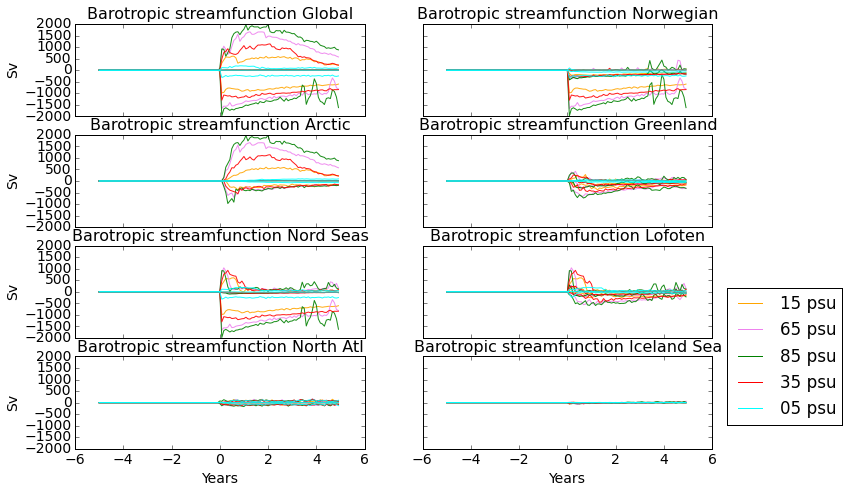

In [212]:
# Plot sea surface elevation per regions
def plot_dynStLayers(dic,col_dic,name,row=4,col=2):
    # this function is meant to plot monitor variables
    fig, axes = plt.subplots(row,col,sharex=True,sharey=True)
    handles = []    
    labels = []
    for el in dic:
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] 
        grid = grid_read(data_pert.res)
        mask1,mask2,mask3,mask4,mask5,mask6,mask7,mask8 = region_mask(data_pert.res)
        mask0 = np.ones_like(mask1)
        areamasks = {0:mask0 , 1 : mask1 , 2 : mask2 , 3 : mask3, \
                    4 : mask4, 5 : mask5, 6 : mask6, 7: mask7, 8 : mask8}
        region_titles = reg_titles()
        ax_ind = 0
        alphavar = {'mean':1,'max':0.9,'min':0.9}

        for reg in [0,4,1,5,2,6,3,7]:
            maskcalc = np.tile(areamasks[reg][0,:,:],(data_pert.psi.shape[0],1,1))
            data = np.array(data_pert.psi[:,:,0:data_pert.psi.shape[2]-1])
            data1 = np.array(data_diff.psi)[0:data.shape[0],:,0:data_pert.psi.shape[2]-1]
            datam = (data - data1)*maskcalc            
            datadic = {'mean' : np.nanmean(np.nanmean(datam[:,:,:],axis=2),axis=1) ,
                       'max'  : np.nanmax(np.nanmax(datam[:,:,:],axis=2),axis=1) ,
                       'min'  : np.nanmin(np.nanmin(datam[:,:,:],axis=2),axis=1) }                
            for var in ['mean','max','min']:
                if var == 'mean':
                    h = axes.flat[ax_ind].plot(data_diff.years[:]-5,datadic[var][:],color=col_dic[el],
                                      alpha=alphavar[var],label=el)
                    if el not in labels:
                        handles.append(h[0])
                        labels.append(el)
                else:
                    axes.flat[ax_ind].plot(data_diff.years[:]-5,datadic[var][:],color=col_dic[el],
                                      alpha=alphavar[var])
                axes.flat[ax_ind].set_title('Barotropic streamfunction '+region_titles[reg],fontsize=16)
                axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)
                if (ax_ind)%2 == 0:
                    axes.flat[ax_ind].set_ylabel('Sv',fontsize=14)
                axes.flat[6].set_xlabel('Years',fontsize=14)
                axes.flat[7].set_xlabel('Years',fontsize=14)
            ax_ind += 1
    labels, handles = zip(*sorted(zip(labels, handles)))
    print labels
    plt.legend(handles=handles,labels=labels,bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,)
    fig.subplots_adjust(right=1.6,top=1.6)   
    #fig.savefig('/noc/users/am8e13/Figures/mpert_psi_'+name,dpi=dpires, bbox_inches='tight')
    return labels,handles
#plot_dynStLayers(pert_dic,pert_col)
labels,handles = plot_dynStLayers(pert_conc,pert_conc_col,'conc')
#handles = plot_dynStLayers(pert_size,pert_size_col,'size')
#plot_dynStLayers(pert_time,pert_time_col,'time')
#plot_dynStLayers(pert_res,pert_res_col,'res')

In [195]:
pert_res_col = { "36 km" : 'blue', "18 km" : 'red' , "9 km" : 'black'}
labels,hand = pert_res_col.keys(),pert_res_col.values()

In [196]:
labels,hand

(['18 km', '36 km', '9 km'], ['red', 'blue', 'black'])

In [177]:
#handles = [handles[j][0] for j in range(len(handles))]
#labels = [handles[j].get_label() for j in range(len(handles))]

handles = set(handles)
labels = set(labels)

In [209]:
labels1, handles1 = zip(*sorted(zip(labels, handles)))

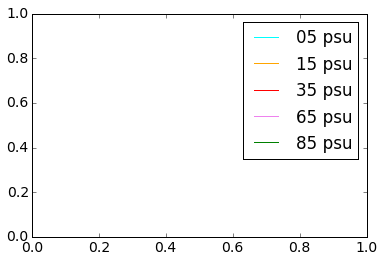

In [210]:
plt.legend(handles1,labels1)

# Steric response 

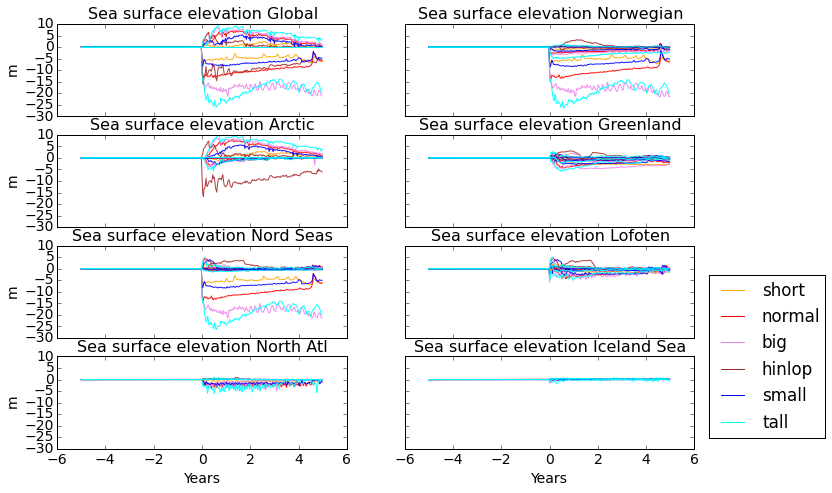

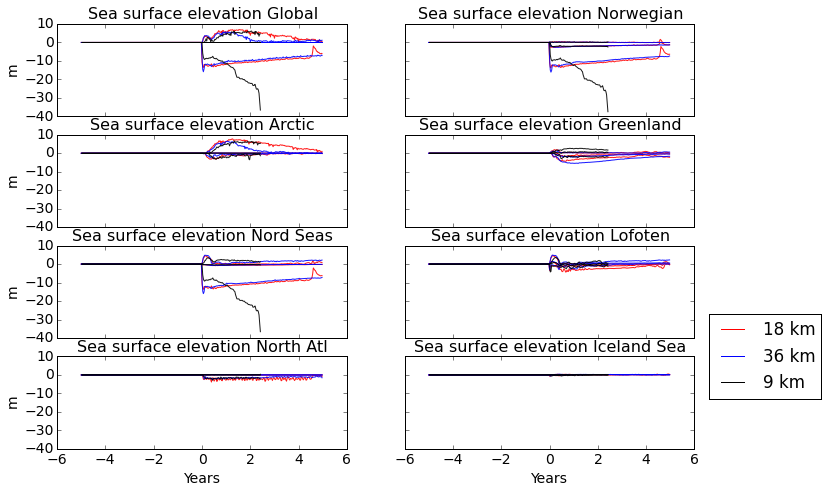

In [508]:
# Plot sea surface elevation per regions
def plot_dynStLayers(dic,col_dic,name,row=4,col=2):
    # this function is meant to plot monitor variables   
    fig, axes = plt.subplots(row,col,sharex=True,sharey=True)    
    region_titles = reg_titles()
    var_s = ['eta_mean','eta_min','eta_max']
    vartitles = {'eta_mean' : 'Eta Mean','eta_max' : 'Eta Max','eta_min' : 'Eta Min'}
    alphavar = {'eta_mean':1,'eta_max':0.9,'eta_min':0.9}
    ls_dic = { 36 : '-' , 18 : '--' , 9 : '..' }
    colvar = {'eta_mean':'black','eta_max':'red','eta_min':'blue'}
    for el in dic:
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] 
        ax_ind = 0
        for reg in [0,4,1,5,2,6,3,7]:
            for var in ['eta_mean','eta_max','eta_min']:                    
                nt1 = data_pert.dataDyn[var][:,reg,0].shape[0]
                nt2 = data_diff.dataDyn[var][:,reg,0].shape[0]
                nt = min(nt1,nt2)
                data = data_pert.dataDyn[var][1:nt,reg,0] - data_diff.dataDyn[var][1:nt,reg,0]
                if data_pert.res == 9:
                    beg = 1
                    yer = 5
                else:
                    beg = 0
                    yer = 5
                if var == 'eta_mean':
                    axes.flat[ax_ind].plot(data_diff.dataDyn['time_lv_years'][beg:nt]-yer,data[:],
                                    color=col_dic[el],alpha=alphavar[var],label=el)
                else:
                    axes.flat[ax_ind].plot(data_diff.dataDyn['time_lv_years'][beg:nt]-yer,data[:],
                                    color=col_dic[el],alpha=alphavar[var])
                axes.flat[ax_ind].set_title('Sea surface elevation '+region_titles[reg],fontsize=16)
                if (ax_ind)%2 == 0:
                    axes.flat[ax_ind].set_ylabel('m',fontsize=14)
                axes.flat[6].set_xlabel('Years',fontsize=14)
                axes.flat[7].set_xlabel('Years',fontsize=14)
                axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)

            ax_ind += 1
        plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
        fig.subplots_adjust(right=1.6,top=1.6)
    fig.savefig('/noc/users/am8e13/Figures/mpert_ssh_'+name,dpi=dpires, bbox_inches='tight')

#plot_dynStLayers(pert_dic,pert_col)
#plot_dynStLayers(pert_conc,pert_conc_col,'conc')
plot_dynStLayers(pert_size,pert_size_col,'size')
#plot_dynStLayers(pert_time,pert_time_col,'time')
plot_dynStLayers(pert_res,pert_res_col,'res')

# Fluxes

Most of the flux seems to go through Fram strait, very little through Barents strait or Denmark strait, we check fluxes to confirm this

Fluxes are positives for fluxes into the Arctic

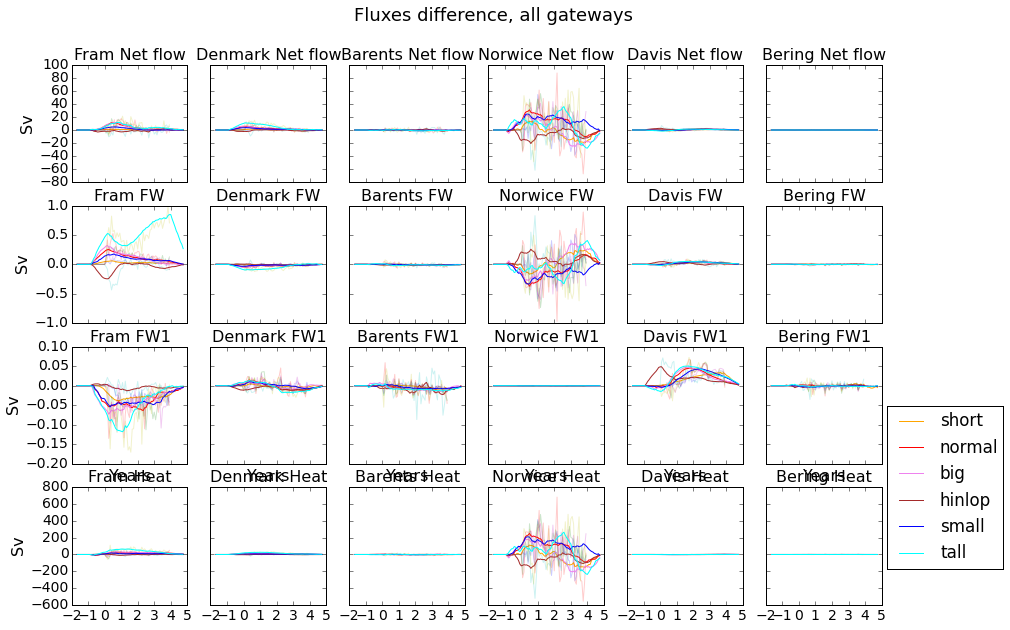

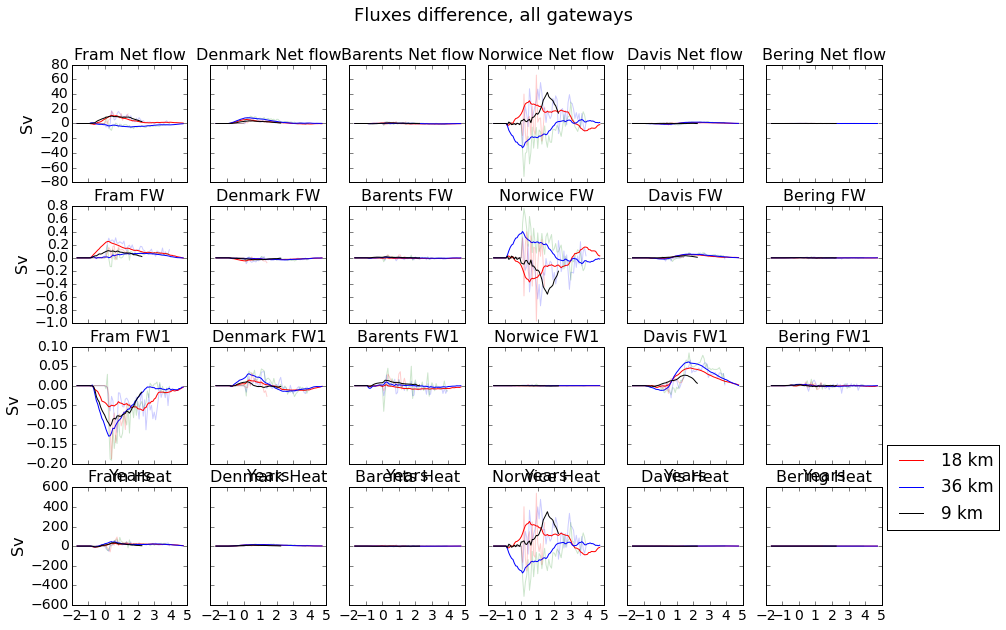

In [509]:
def plot_flux_total_diff(dic,col_dic,name):
    # this function is meant to plot monitor variables   
    fluxes = ['FluxSum','FluxSumFW','FluxSumFW1','FluxSumT']#
    variables = ['Fram','Denmark','Barents','Norwice','Davis','Bering']
    #variables = ['Fram','Denmark']
    flux_titles = {'FluxSumFW' : 'FW','FluxSumFW1' : 'FW1','FluxSumS' : 'S', 'FluxSumT':'Heat', \
                   'FluxInSum' : 'Inflow','FluxOutSum' : 'Outflow' , 'FluxSum' : 'Net flow'}
    var_titles = {'Fram' : 'Fram' , 'Fram1' : 'Fram' , 'Fram2' : 'Fram' , 
                  'Davis': 'Davis' , 'Davis1': 'Davis' , 'Davis2': 'Davis',
                 'Denmark' : 'Denmark' , 'Bering' : 'Bering' , 'Norwice' : 'Norwice' ,'Norwice2' : 'Norwice2' ,
                 'Barents' : 'Barents' , 'Barents1' : 'Barents' , 'Barents2' : 'Barents'}
    
    iniz = 40
    fig, axes = plt.subplots(len(fluxes),len(variables),sharex=True,sharey='row')
    for el in dic:
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"]
        ax_ind = 0
        for flux in fluxes:
            for var in variables:  
                data = data_pert.fluxes[var][flux]-data_diff.fluxes[var][flux]
                axes.flat[ax_ind].plot(data_diff.years[iniz:-12]-5,data[iniz:-12],alpha=0.2)
                axes.flat[ax_ind].plot(data_diff.years[iniz:-2]-5,runningMeanFast(data,12)[iniz:-2],\
                                       color=col_dic[el],label=el)
                axes.flat[ax_ind].set_title(var + flux ,fontsize=16)
                if ax_ind%len(variables)==0:
                    axes.flat[ax_ind].set_ylabel('Sv',fontsize=16)
                if ax_ind/len(variables)==2:
                    axes.flat[ax_ind].set_xlabel('Years',fontsize=16)
                axes.flat[ax_ind].set_title(var_titles[var]+' '+flux_titles[flux],fontsize=16)
                axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)            
                ax_ind += 1
        plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
    fig.subplots_adjust(right=2.,top=2.)
    fig.suptitle("Fluxes difference, all gateways",x=1.1,y=2.2,fontsize=18)  
    fig.savefig('/noc/users/am8e13/Figures/mpert_flows_'+name,dpi=dpires, bbox_inches='tight')

#plot_flux_total_diff(pert_dic,pert_col)
#plot_flux_total_diff(pert_conc,pert_conc_col,'conc')
plot_flux_total_diff(pert_size,pert_size_col,'size')
#plot_flux_total_diff(pert_time,pert_time_col,'time')
plot_flux_total_diff(pert_res,pert_res_col,'res')

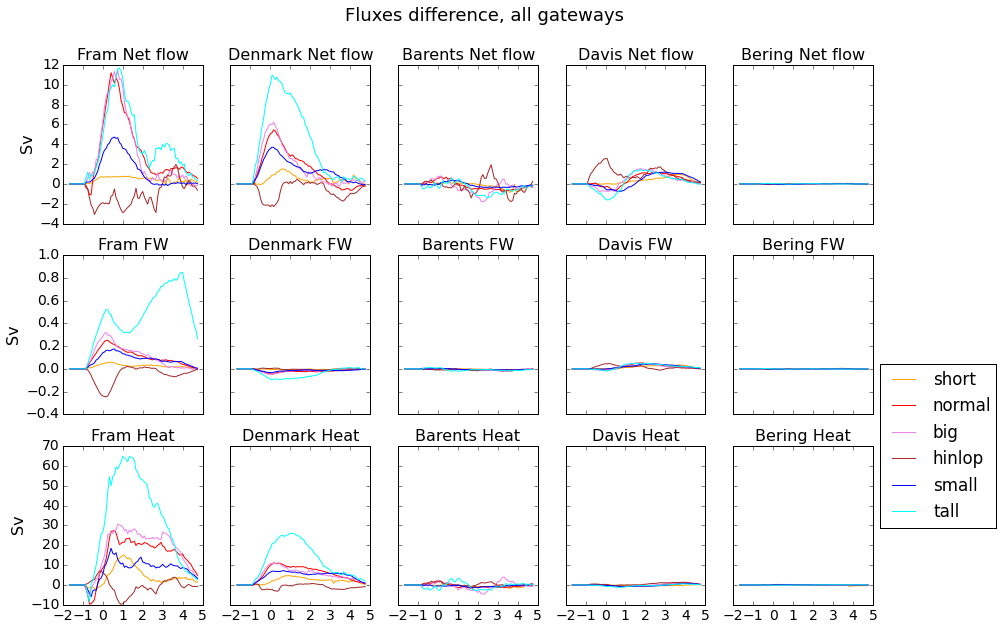

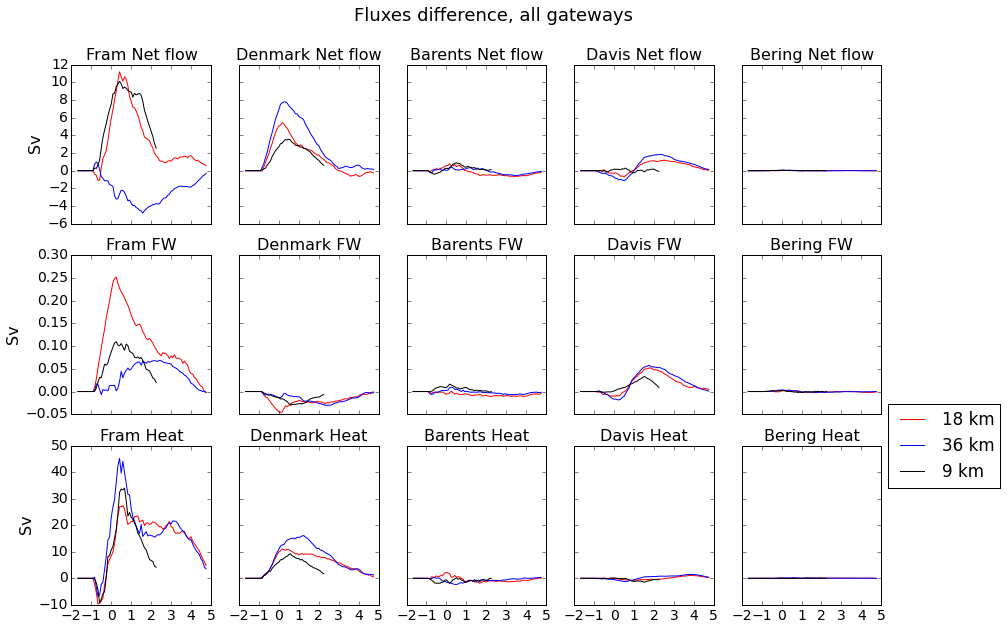

In [510]:
def plot_flux_total_diff(dic,col_dic,name):
    # this function is meant to plot monitor variables   
    fluxes = ['FluxSum','FluxSumFW','FluxSumT']#
    variables = ['Fram','Denmark','Barents','Davis','Bering']
    #variables = ['Fram','Denmark']
    flux_titles = {'FluxSumFW' : 'FW','FluxSumFW1' : 'FW1','FluxSumS' : 'S', 'FluxSumT':'Heat', \
                   'FluxInSum' : 'Inflow','FluxOutSum' : 'Outflow' , 'FluxSum' : 'Net flow'}
    var_titles = {'Fram' : 'Fram' , 'Fram1' : 'Fram' , 'Fram2' : 'Fram' , 
                  'Davis': 'Davis' , 'Davis1': 'Davis' , 'Davis2': 'Davis',
                 'Denmark' : 'Denmark' , 'Bering' : 'Bering' , 'Norwice' : 'Norwice' ,'Norwice2' : 'Norwice2' ,
                 'Barents' : 'Barents' , 'Barents1' : 'Barents' , 'Barents2' : 'Barents'}
    
    iniz = 40
    fig, axes = plt.subplots(len(fluxes),len(variables),sharex=True,sharey='row')
    for el in dic:
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"]
        ax_ind = 0
        for flux in fluxes:
            for var in variables:  
                data = data_pert.fluxes[var][flux]-data_diff.fluxes[var][flux]
                axes.flat[ax_ind].plot(data_diff.years[iniz:-2]-5,runningMeanFast(data,12)[iniz:-2],\
                                       color=col_dic[el],label=el)
                axes.flat[ax_ind].set_title(var + flux ,fontsize=16)
                if ax_ind%len(variables)==0:
                    axes.flat[ax_ind].set_ylabel('Sv',fontsize=16)
                axes.flat[ax_ind].set_title(var_titles[var]+' '+flux_titles[flux],fontsize=16)
                axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)            
                ax_ind += 1
        plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
    fig.subplots_adjust(right=2.,top=2.)
    fig.suptitle("Fluxes difference, all gateways",x=1.1,y=2.2,fontsize=18)  
    fig.savefig('/noc/users/am8e13/Figures/mpert_flows_'+name,dpi=dpires, bbox_inches='tight')

#plot_flux_total_diff(pert_dic,pert_col)
#plot_flux_total_diff(pert_conc,pert_conc_col,'conc')
plot_flux_total_diff(pert_size,pert_size_col,'size')
#plot_flux_total_diff(pert_time,pert_time_col,'time')
plot_flux_total_diff(pert_res,pert_res_col,'res')

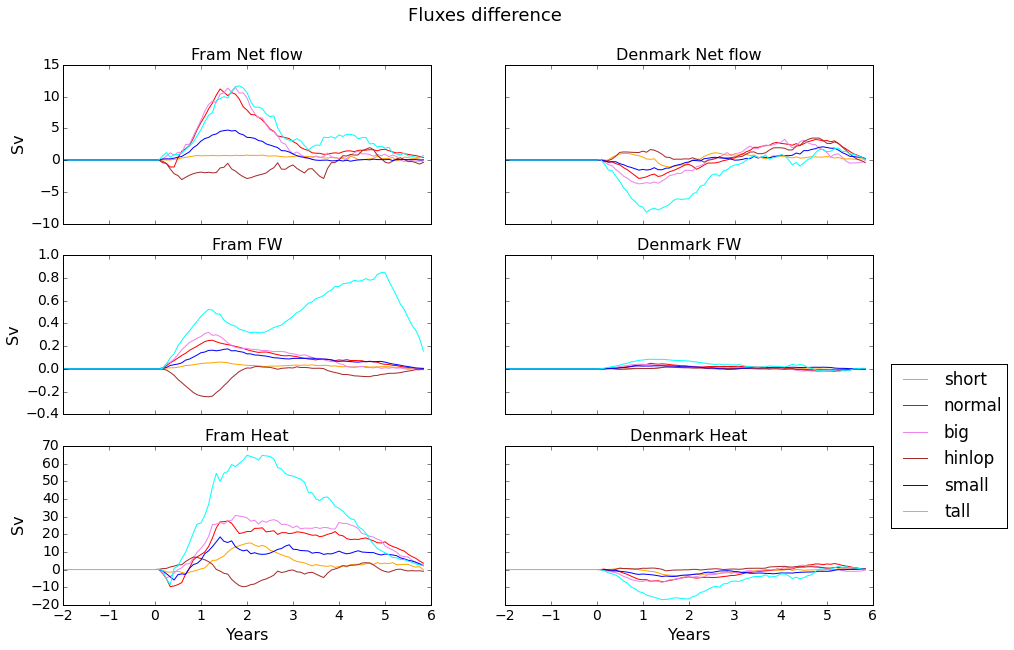

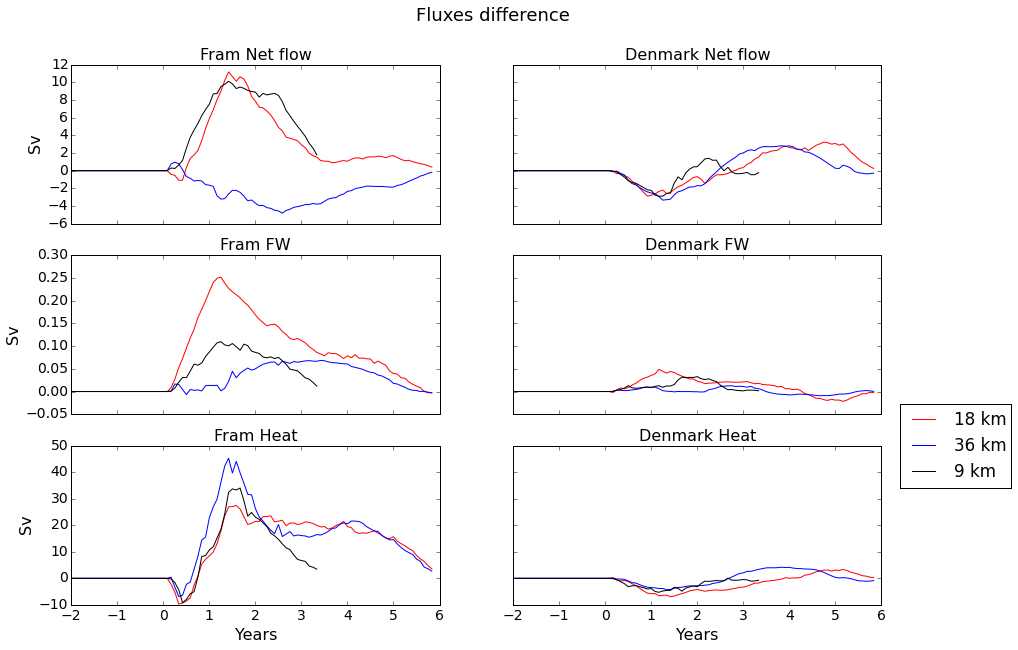

In [511]:
# plot layers
def plot_total_flux(dic,col_dic,name,cum=True,row=2,col=2):
    # this function is meant to plot monitor variables   
    
    fluxes = ['Flux','FluxFW','FluxT']#,'FluxFW1'
    #variables = ['Fram','Barents','Davis','Denmark']
    variables = ['Fram','Denmark']
    flux_titles = {'FluxFW' : 'FW','FluxFW1' : 'FW<35','FluxS' : 'S', 'FluxT':'Heat', \
                   'FluxIn' : 'Inflow','FluxOut' : 'Outflow' , 'Flux' : 'Net flow'}
    var_titles = {'Fram' : 'Fram' , 'Fram1' : 'Fram' , 'Fram2' : 'Fram' , 
                  'Davis': 'Davis' , 'Davis1': 'Davis' , 'Davis2': 'Davis',
                 'Denmark' : 'Denmark' , 'Bering' : 'Bering' , 'Norwice' : 'Norwice' ,
                 'Barents' : 'Barents' , 'Barents1' : 'Barents' , 'Barents2' : 'Barents'}
    #col_dic = {36 : 'blue' , 18 : 'orange' , 9 : 'green'}
    iniz = 24
    fig, axes = plt.subplots(len(fluxes),len(variables),sharex=True,sharey='row')
    for el in dic:
        ax_ind = 0
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] ;  
        for flux in fluxes:
            for var in variables:
                data = data_pert.fluxes2[var][flux]-data_diff.fluxes2[var][flux]
                axes.flat[ax_ind].plot(data_diff.years[iniz:-1]-4,runningMeanFast(np.nansum(np.nansum((
                           data)[:,:,:],axis=2),axis=1),12)[iniz:-1],color=col_dic[el],label=el)
                axes.flat[ax_ind].set_title(var + flux ,fontsize=16)
                if ax_ind%len(variables)==0:
                    axes.flat[ax_ind].set_ylabel('Sv',fontsize=16)
                if ax_ind/len(variables)==2:
                    axes.flat[ax_ind].set_xlabel('Years',fontsize=16)
                axes.flat[ax_ind].set_title(var_titles[var]+' '+flux_titles[flux],fontsize=16)
                axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)            
                ax_ind += 1
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
    fig.subplots_adjust(right=2.,top=2.)
    fig.suptitle("Fluxes difference",x=1.1,y=2.2,fontsize=18)  
    fig.savefig('/noc/users/am8e13/Figures/mpert_davisfram_fluxes_'+name,dpi=dpires, bbox_inches='tight')

#plot_total_flux(pert_dic,pert_col)
#plot_total_flux(pert_conc,pert_conc_col,'conc')
plot_total_flux(pert_size,pert_size_col,'size')
#plot_total_flux(pert_time,pert_time_col,'time')
plot_total_flux(pert_res,pert_res_col,'res')

# Temperature and salinity evolution

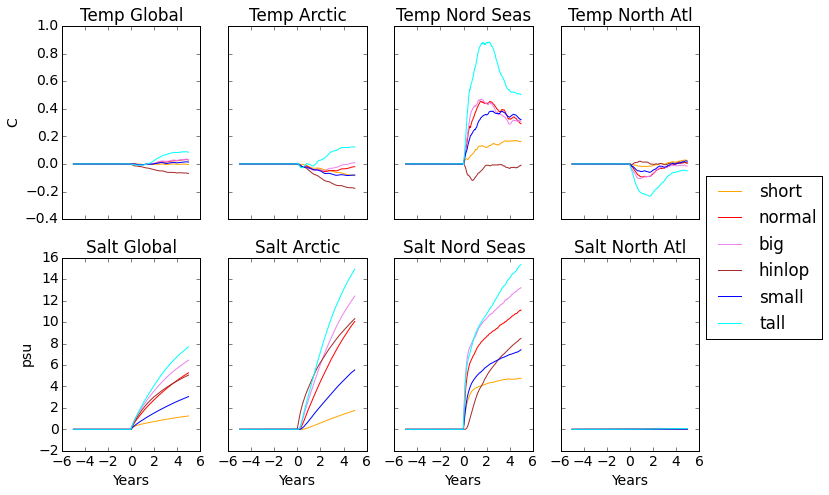

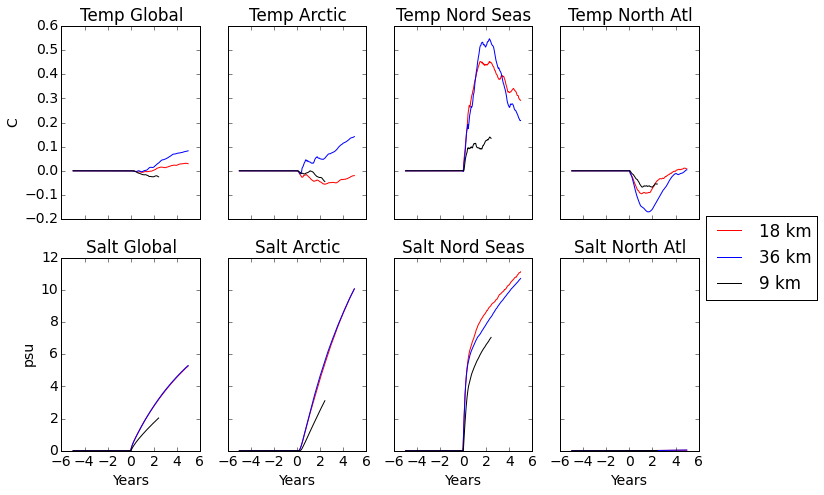

In [512]:
def plot_dynStLayers(dic,col_dic,row=2,col=4):
    # this function is meant to plot monitor variables  
    #col_dic = {36 : 'blue' , 18 : 'orange' , 9 : 'green'}
    region_titles = reg_titles()
    fig, axes = plt.subplots(row,col,sharex=True,sharey='row')
    ax_ind = 0
    var_s = ['theta_mean','salt_mean']
    vartitles = {'theta_mean' : 'Temp', 'salt_mean' : 'Salt'}
    for el in dic:
        ax_ind = 0
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] ;     
        for var in var_s:
            for reg in range(4):
                nt1 = data_pert.dataDyn[var][:,reg,0].shape[0]
                nt2 = data_diff.dataDyn[var][:,reg,0].shape[0]
                nt = min(nt1,nt2)
                data = data_pert.dataDyn[var][1:nt,reg,0] - data_diff.dataDyn[var][1:nt,reg,0]
                if data_pert.res == 9:
                    beg = 1
                    yer = 5
                else:
                    beg = 0
                    yer = 5
                #data = data_pert.dataDyn[var][1:12*10*3,reg,0] - data_diff.dataDyn[var][1:12*10*3,reg,0]
                #datam = runningMeanFast(data,12*3)[:-12*3]                    
                axes.flat[ax_ind].plot(data_diff.dataDyn['time_lv_years'][beg:nt]-yer,data[:],
                                    color=col_dic[el],label=el)
                axes.flat[ax_ind].set_title(vartitles[var]+' '+region_titles[reg])
                axes.flat[0].set_ylabel('C')
                axes.flat[4].set_ylabel('psu')
                axes.flat[4].set_xlabel('Years')
                axes.flat[5].set_xlabel('Years')
                axes.flat[6].set_xlabel('Years')
                axes.flat[7].set_xlabel('Years')
                ax_ind += 1
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
    fig.subplots_adjust(right=1.6,top=1.6)
#plot_dynStLayers(pert_dic,pert_col)
#plot_dynStLayers(pert_conc,pert_conc_col)
plot_dynStLayers(pert_size,pert_size_col)
#plot_dynStLayers(pert_time,pert_time_col)
plot_dynStLayers(pert_res,pert_res_col)

#Freshwater content in Arctic and Nordic Seas

Now we want to study more in the details the changes in freshwater content cause by the perturbation.

Here we consider the freshwater content in the first 1000m of the water column.

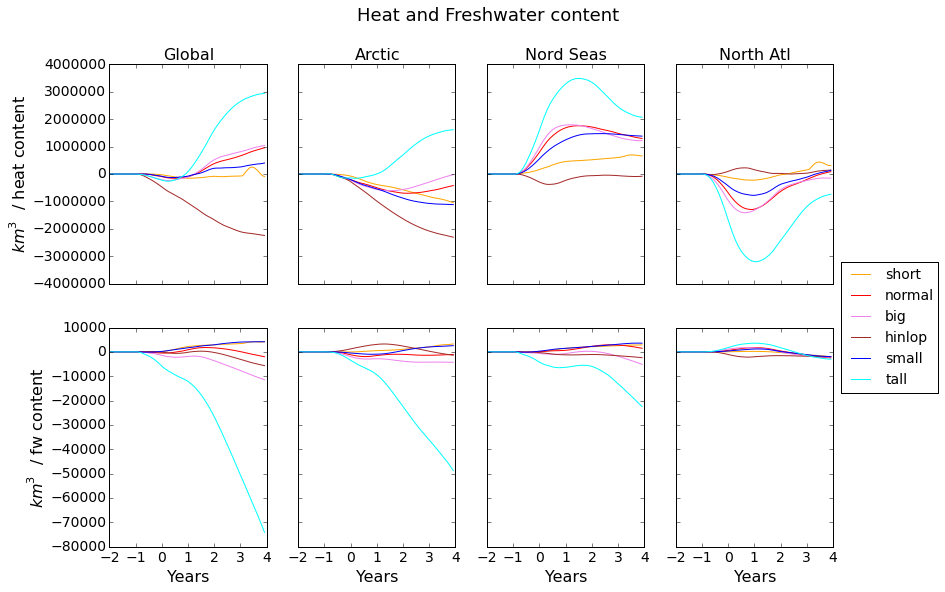

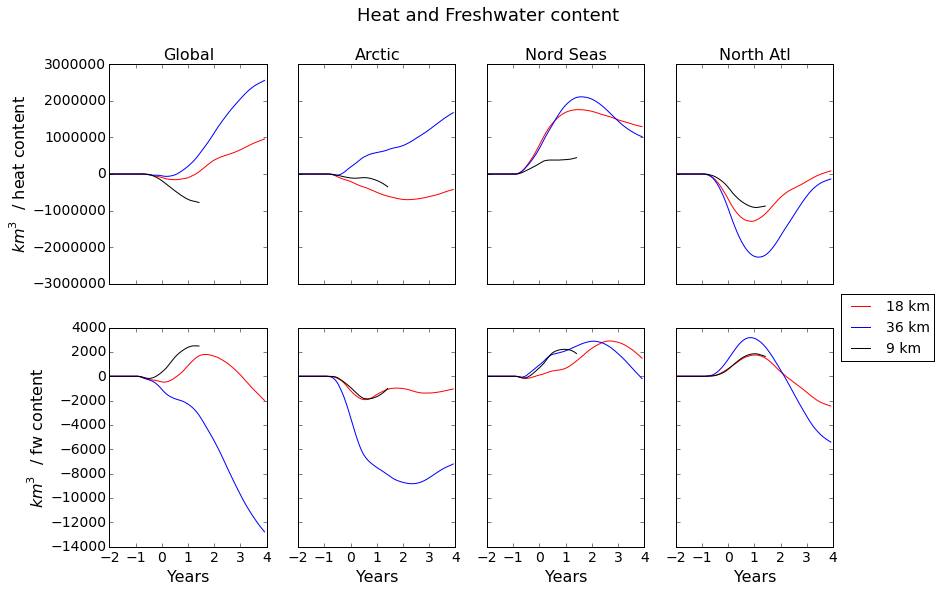

In [513]:
def plot_freshwater_content(dic,col_dic):
    titles = reg_titles()
    #col_dic = {36 : 'blue' , 18 : 'orange' , 9 : 'green'}
    fig , axes = plt.subplots(2,4,sharex=True,sharey='row')

    for el in dic:
        j = 0
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] ;   
        for j in range(4):        
            nt = len(data_pert.freshwater_levels[j,:])
            colormap = matplotlib.cm.jet 
            colors = [colormap(i) for i in np.linspace(0, 1,30)]
            iniz = 36

            datam = np.nansum(data_pert.heat_levels[j,:,0:] - data_diff.heat_levels[j,:nt,0:],axis=1)                
            axes.flat[j].plot(data_diff.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                            color=col_dic[el],label=el)  

            datam = np.nansum(data_pert.freshwater_levels[j,:,0:30] - data_diff.freshwater_levels[j,:nt,0:30],axis=1)                
            axes.flat[j+4].plot(data_diff.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                            color=col_dic[el],label=el)  
            axes.flat[j].set_title(titles[j],fontsize=16)

            axes.flat[0].set_ylabel(r'$km^3$ / heat content',fontsize=16)
            axes.flat[4].set_ylabel(r'$km^3$ / fw content',fontsize=16)
            axes.flat[j+4].set_xlabel('Years',fontsize=16)
            axes.flat[j].tick_params(axis='both', which='major', labelsize=14)
            axes.flat[j+4].tick_params(axis='both', which='major', labelsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,fontsize=14)
    fig.suptitle("Heat and Freshwater content ",x=1.,y=2.,fontsize=18)      
    fig.subplots_adjust(right=1.8,top=1.8)
    #fig.savefig('/noc/users/am8e13/Figures/mixed_hcfw',dpi=dpires, bbox_inches='tight')

#plot_freshwater_content(pert_dic,pert_col)
#plot_freshwater_content(pert_conc,pert_conc_col)
plot_freshwater_content(pert_size,pert_size_col)
#plot_freshwater_content(pert_time,pert_time_col)
plot_freshwater_content(pert_res,pert_res_col)


# Mixed layer depth

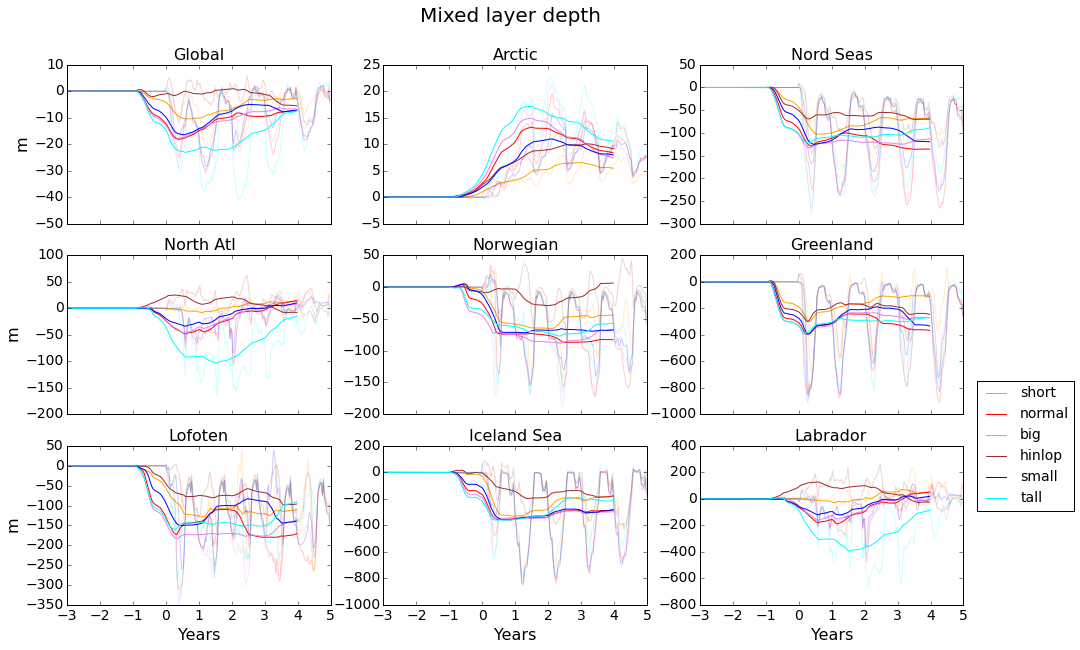

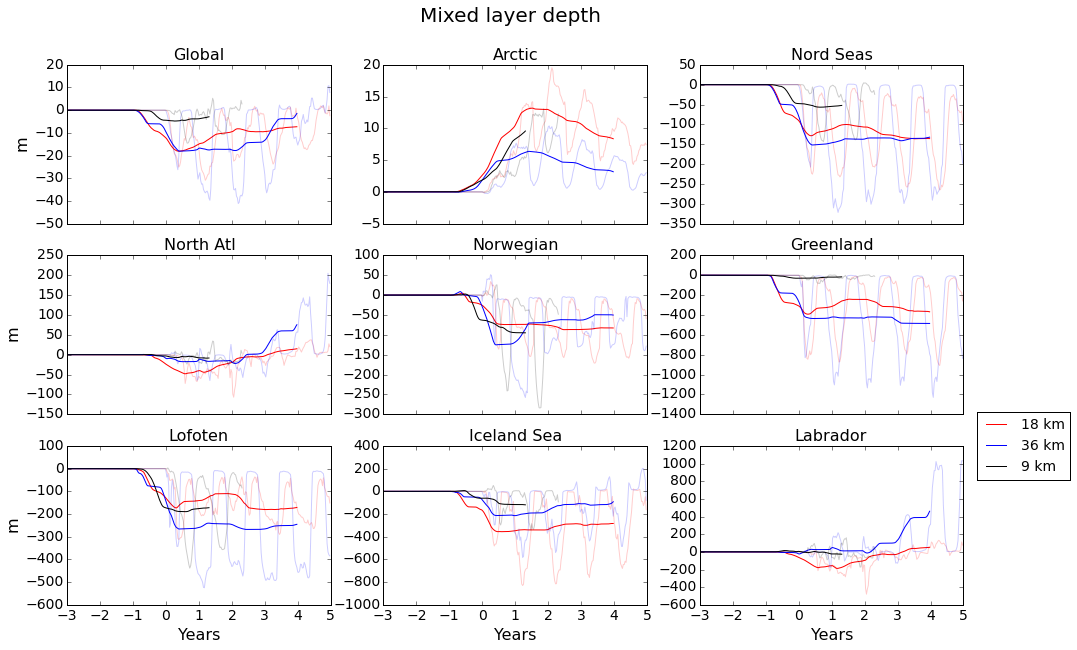

In [514]:
def plot_mxldepth(dic,col_dic,name):
    reg_title = reg_titles()
    fig , axes = plt.subplots(3,3,sharey=False,sharex=True)
    #col_dic = {36 : 'blue' , 18 : 'orange' , 9 : 'green'}
    for el in dic:
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] ; 
        for j in range(len(reg_title)):
            #data = data_pert.mxldepth_mean[j] - data_diff.mxldepth_mean[j]
            data = data_diff.mxldepth_mean[j] - data_pert.mxldepth_mean[j]
            axes.flat[j].plot(data_diff.mxldepth_years[24*3:]-5,-data[24*3:],alpha=0.2,color=col_dic[el])
            axes.flat[j].plot(data_diff.mxldepth_years[24*3:-12*3]-5,-runningMeanFast(data,12*3)[24*3:-12*3],\
                              color=col_dic[el],label=el)
          
            axes.flat[j].set_title(reg_title[j],fontsize=16)   
        axes.flat[6].set_xlabel('Years',fontsize=16)
        axes.flat[7].set_xlabel('Years',fontsize=16)
        axes.flat[8].set_xlabel('Years',fontsize=16)
        axes.flat[0].set_ylabel('m',fontsize=16)
        axes.flat[3].set_ylabel('m',fontsize=16)
        axes.flat[6].set_ylabel('m',fontsize=16)    
        
    #for j in range(len(reg_title)):       
        #axes.flat[j].plot(data_diff.mxldepth_years[24*3:]-5,-data_diff.mxldepth_mean[j][24*3:],\
        #        alpha=0.2,color='black')
        #axes.flat[j].plot(data_diff.mxldepth_years[24*3:-12*3]-5,\
        #        -runningMeanFast(data_diff.mxldepth_mean[j],12*3)[24*3:-12*3],color='black',label='Control')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,fontsize=14)
    fig.subplots_adjust(right=2.2,top=2.)
    fig.suptitle("Mixed layer depth",x=1.15,y=2.2,fontsize=20)
    fig.savefig('/noc/users/am8e13/Figures/mpert_mxld_'+name,dpi=dpires, bbox_inches='tight')

#plot_mxldepth(pert_dic,pert_col)
#plot_mxldepth(pert_conc,pert_conc_col,'conc')
plot_mxldepth(pert_size,pert_size_col,'size')
#plot_mxldepth(pert_time,pert_time_col,'time')
plot_mxldepth(pert_res,pert_res_col,'res')

# Seaice

We look at the seaice to see if the excess in freshwater could be caused by a decrease in seaice

ValueError: x and y must have same first dimension

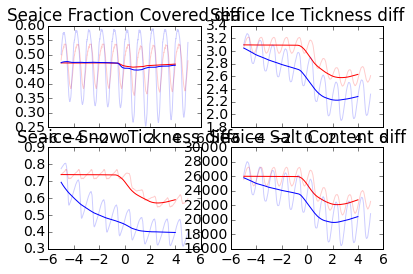

In [515]:
def plot_seaice(dic,col_dic,name):
    variables = ['seaice_area_mean' , 'seaice_heff_mean','seaice_hsnow_mean','seaice_hsalt_mean']
    titles = {'seaice_area_mean' : 'Seaice Fraction Covered', 'seaice_heff_mean' : 'Seaice Ice Tickness',
              'seaice_hsnow_mean' : 'Seaice Snow Tickness', 'seaice_hsalt_mean' : 'Seaice Salt Content'}
    fig , axes = plt.subplots(2,2)
    for el in dic:
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] ;     
        nt = len(data_diff.data['time_years_ice'])
        for j in range(4): 
            data = data_pert.data[variables[j]][0:nt] #- data_diff.data[variables[j]][0:nt]        
            axes.flat[j].plot(data_diff.data['time_years_ice']-5,data,alpha=0.2,\
                              color=col_dic[el])
            axes.flat[j].plot(data_diff.data['time_years_ice'][0:-360]-5,runningMeanFast(data,360)[0:-360],\
                             color=col_dic[el],label=el)
            axes.flat[j].set_title(titles[variables[j]]+' diff')  
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,fontsize=14)
    fig.suptitle('Seaice',x=1.1,y=2.2,fontsize=22)
    fig.subplots_adjust(right=2.2,top=2.)
    fig.savefig('/noc/users/am8e13/Figures/mpert_seiace_'+name,dpi=dpires, bbox_inches='tight')
#plot_seaice(pert_dic,pert_col)
#plot_seaice(pert_conc,pert_conc_col,'conc')
#plot_seaice(pert_time,pert_time_col,'time')
#plot_seaice(pert_size,pert_size_col,'size')
plot_seaice(pert_res,pert_res_col,'res')

# Overflow calculation

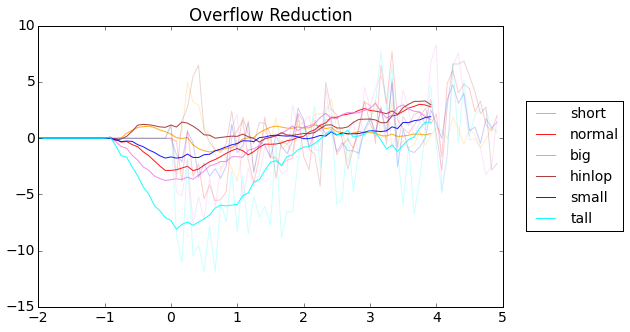

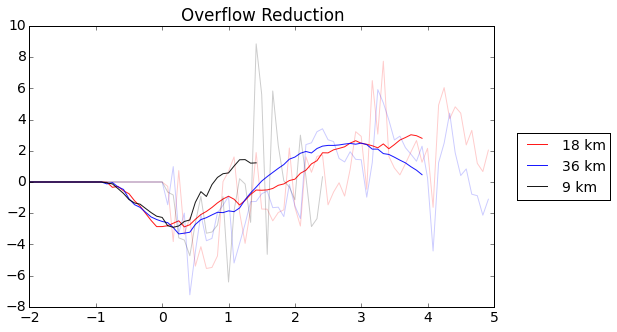

In [516]:
def plot_overflow(dic,col_dic,name):
    rho0 = 1027.8
    var = 'Flux' 
    fig , axes = plt.subplots(1,1,sharey=False,sharex=True)
    for el in dic:  
        kdic = {36:1,18:2,9:4}
        kk = kdic[dic[el]['const'].res]
        data_pert = dic[el]["const"] ; data_diff = dic[el]["bench"] ;  
        iniz = 36
        plt.plot(data_diff.years[iniz:]-5,data_pert.fluxes2['Denmark']['FluxSumOverFlow'][iniz:] - 
                 data_diff.fluxes2['Denmark']['FluxSumOverFlow'][iniz:] ,alpha=0.2,color=col_dic[el])
        plt.plot(data_diff.years[iniz:-12]-5,runningMeanFast(data_pert.fluxes2['Denmark']['FluxSumOverFlow'] - 
                                data_diff.fluxes2['Denmark']['FluxSumOverFlow'],12)[iniz:-12],
                    alpha=0.9,color=col_dic[el],label=el)                
        
        #plt.plot(data_diff.years-5,data_pert.fluxes2['Denmark']['FluxSumOverFlow'],alpha=0.2,color=col_dic[el])
        #plt.plot(data_diff.years[0:-12]-5,runningMeanFast(data_pert.fluxes2['Denmark']['FluxSumOverFlow'],12)[0:-12],
        #            alpha=0.9,color=col_dic[el],label=el)        
    plt.title('Overflow Reduction')
    plt.legend(bbox_to_anchor=(1.05,0.5), loc=6, borderaxespad=0.,fontsize=14)    
    fig.subplots_adjust(right=1.2,top=1.1)
    fig.savefig('/noc/users/am8e13/Figures/mpert_overflow_'+name,dpi=dpires, bbox_inches='tight')
#plot_overflow(pert_dic)
#plot_overflow(pert_conc,pert_conc_col,'conc')
#plot_overflow(pert_time,pert_time_col,'time')
plot_overflow(pert_size,pert_size_col,'size')
plot_overflow(pert_res,pert_res_col,'res')



In [ ]:
runs = {"const" : pert_const_18, "bench" : pert_bench_18 , "pert_36" : pert_const_36,\
        "pert_1y_18" :  pert_1y_18 , "pert_50_18" : pert_50_18 , "pert_70_18" : pert_70_18, \
        "pert_120_18" : pert_120_18, "pert_small_18" : pert_small_18 }

In [ ]:
conc_comp = {"const" : pert_const_18, "bench" : pert_bench_18 , \
        "pert_50_18" : pert_50_18 , "pert_70_18" : pert_70_18, \
        "pert_120_18" : pert_120_18, "pert_40_18" : pert_40_18 ,}

time_comp = {"const" : pert_const_18 , "bench" : pert_bench_18 , 'pert_1y_rest_18':pert_1y_rest_18 , \
             "pert_1y_18":pert_1y_18}

res_comp = {"const" : pert_const_18 , "bench" : pert_bench_18 , 'pert_const_36':pert_const_36 , \
             "pert_const_9":pert_const_9}

In [588]:
reg_names

['global','arctic','nordseas','norhtatl','norwegian','greenland','lofoten','iceland','labrador']

{0: 'Global',
 1: 'Arctic',
 2: 'Nord Seas',
 3: 'North Atl',
 4: 'Lorwegian',
 5: 'Greenland',
 6: 'Lofoten',
 7: 'Iceland Sea',
 8: 'Labrador'}

In [593]:
def compare_data(run):
    run.comp_data = {}
    run.comp_data = {'eta_min' : np.zeros(11), 'eta_max' : np.zeros(11) , 'eta_mean' : np.zeros(11) ,\
                     'psi_min' : np.zeros(11), 'psi_max' : np.zeros(11) , 'psi_mean' : np.zeros(11) ,\
                     'mxld_min' : np.zeros(11) , 'mxld_max' : np.zeros(11) , 'mxld_mean' : np.zeros(11) ,\
                     'ovfl_min' : np.zeros(11) , 'ovfl_max' : np.zeros(11) ,'ovfl_mean' : np.zeros(11) ,\
                    'Fram_flux_min':np.zeros(1), 'Fram_flux_max':np.zeros(1), 'Fram_flux_mean':np.zeros(1),\
                    'Fram_fwflux_min':np.zeros(1),'Fram_fwflux_max':np.zeros(1),'Fram_fwflux_mean':np.zeros(1),\
                    'Fram_tflux_min':np.zeros(1),'Fram_tflux_max':np.zeros(1),'Fram_tflux_mean':np.zeros(1),\
                'Fram_overflow_min':np.zeros(1),'Fram_overflow_max':np.zeros(1),'Fram_overflow_mean':np.zeros(1),\
                 'Denmark_flux_min':np.zeros(1),'Denmark_flux_max':np.zeros(1),'Denmark_flux_mean':np.zeros(1),\
             'Denmark_fwflux_min':np.zeros(1),'Denmark_fwflux_max':np.zeros(1),'Denmark_fwflux_mean':np.zeros(1),\
            'Denmark_tflux_min':np.zeros(1),'Denmark_tflux_max':np.zeros(1),'Denmark_tflux_mean':np.zeros(1),\
        'Denmark_overflow_min':np.zeros(1),'Denmark_overflow_max':np.zeros(1),'Denmark_overflow_mean':np.zeros(1)}
    
    grid = grid_read(run.res)
    mask1,mask2,mask3,mask4,mask5,mask6,mask7,mask8 = region_mask(run.res)
    mask0 = np.ones_like(mask1)
    areamasks = {0:mask0 , 1 : mask1 , 2 : mask2 , 3 : mask3, \
                    4 : mask4, 5 : mask5, 6 : mask6, 7: mask7, 8 : mask8}
    
    init = 5*12 + 2*12 + 5
    rnames = ['global','arctic','nordseas','norhtatl','norwegian','greenland','lofoten','iceland','labrador']
    for j in range(len(reg_titles())):
        reg = rnames[j]
        run.comp_data['mxld_mean_'+reg] = -np.nanmean(run.mxldepth_mean[j][init:])
        run.comp_data['mxld_max_'+reg] = -np.nanmax(run.mxldepth_mean[j][init:])
        run.comp_data['mxld_min_'+reg] = -np.nanmin(run.mxldepth_mean[j][init:])
        
        run.comp_data['eta_mean_'+reg] = np.nanmean(run.dataDyn['eta_mean'][init*3:,j,0])
        run.comp_data['eta_max_'+reg] = np.nanmax(run.dataDyn['eta_max'][init*3:,j,0])
        run.comp_data['eta_min_'+reg] = np.nanmin(run.dataDyn['eta_min'][init*3:,j,0])
        
        maskcalc = np.tile(areamasks[j][0,:,:],(run.psi.shape[0],1,1))
        data = np.array(run.psi[:,:,0:run.psi.shape[2]-1])*maskcalc
        run.comp_data['psi_mean_'+reg] = np.nanmean(data[init:,:,:])
        run.comp_data['psi_max_'+reg] = np.nanmax(data[init:,:,:])
        run.comp_data['psi_min_'+reg] = np.nanmin(data[init:,:,:])
    
    opdic = {'max':np.nanmax,'min':np.nanmin,'mean':np.nanmean}
    fldic = {'flux':'FluxSum','tflux':'FluxSumT','fwflux':'FluxSumFW','overflow':'FluxSumOverFlow'}
    
    for loc in ['Denmark','Fram']:
        for fl in ['flux','tflux','fwflux','overflow']:
            for op in ['max','min','mean']:
                var = loc+'_'+fl+'_'+op
                func = opdic[op]
                run.comp_data[var][0] = func(run.fluxes2[loc][fldic[fl]][init:])
        
    
    #run.comp_data['psi_max'][0] = np.nanmax(data[60:,:,:])
    #run.comp_data['psi_min'][j] = np.nanmin(data[60:,:,:])

def create_compare(dic):
    for el in dic:
        compare_data(dic[el])

In [544]:
# salt added
# this function calculates the amount of salt added to the perturbation by in every simulation
def salt_q_calc(run,value,mask='',mult=1):
    path = '/scratch/general/am8e13/perturbation_fields/'
    ydim = len(run.X) ; xdim = len(run.Y) ; zdim = len(run.Z)
    mask_read = komod.mitbin(path+'pertSMask_'+mask+str(run.res)+'km',xdim=xdim,ydim=ydim,zdim=zdim,tdim=1,datatype='float32')
    mask_read = np.squeeze(mask_read,axis=0)
    values_read = komod.mitbin(path+'pertSValue_'+value,xdim=xdim,ydim=ydim,zdim=zdim,tdim=1,datatype='float32')
    values_read = np.squeeze(values_read,axis=0)
    
    grid = grid_read(run.res)
    run.salt_amount = np.nansum(mask_read*values_read*grid['Area'])*mult

salt_q_calc(pert_120_18,'18km_120')   
salt_q_calc(pert_70_18,'18km_70')
salt_q_calc(pert_50_18,'18km_50')
salt_q_calc(pert_40_18,'18km_40')
salt_q_calc(pert_small_18,'small_18km_100','short_') 
salt_q_calc(pert_big_18,'big_18km_100','big_') 
salt_q_calc(pert_tall_18,'tall_18km_100','tall_') 
salt_q_calc(pert_short_18,'short_18km_100','short_') 
salt_q_calc(pert_const_36,'36km_100') 
salt_q_calc(pert_1y_18,'18km_100',mult=0.2) 
salt_q_calc(pert_1y_rest_18,'18km_100',mult=0.2) 
salt_q_calc(pert_bench_18,'18km_100',mult=0)
salt_q_calc(pert_bench_36,'36km_100',mult=0)
salt_q_calc(pert_bench_9,'9km_100',mult=0)
salt_q_calc(pert_hinlop_18,'hinlop_18km_100',mask='hinlop_',mult=1)

In [571]:
pert_dic = {"65 psu 18km" : pert_const_18, "65 psu 36km" : pert_const_36,  "65 psu 9km" : pert_const_9 ,
            "1y 18km" : pert_1y_18, "1y rest 18km" : pert_1y_rest_18,
            "5 psu 18km" : pert_40_18, "15 psu 18km" : pert_50_18, "35 psu 18km": pert_70_18,\
            "85 psu 18km" : pert_120_18,
            "small" : pert_small_18, "big 18km" : pert_big_18, 'tall 18km' : pert_tall_18, 
            "short" : pert_short_18 , 'hinlopen' : pert_hinlop_18 ,
           'control 36km' : pert_bench_36 ,'control 18km' : pert_bench_18 ,'control 9km' : pert_bench_9 ,\
            }

In [594]:
create_compare(pert_dic)

In [546]:
pert_style = {"65 psu 18km" : 'bo', "65 psu 36km" : 'ro',  "65 psu 9km" : 'ko' ,
            "1y 18km" : 'gs', "1y rest 18km" : 'g^',
            "5 psu 18km" : 'cs', "15 psu 18km" : 'c^', "35 psu 18km": 'c<',\
            "85 psu 18km" : 'c>',
            "small" : 'mD', "big 18km" : 'mH', 'tall 18km' : 'm*', 
            "short" : 'mh' , 'hinlopen' : 'mv' ,
           'control 36km' : 'rd' ,'control 18km' : 'bd','control 9km' : 'kd' ,\
            }

In [603]:
var_titles = {'Fram_flux_mean' : 'Fram flux mean','Fram_fwflux_mean' : 'Fram FW flux mean',\
            'Denmark_flux_mean' : 'Denmark flux mean', 'Denmark_fwflux_mean' : 'Denmark FW flux mean',\
            'Denmark_overflow_mean' : 'Denmark overflow mean','Denmark_overflow_min' : 'Denmark overflow min', \
            'Denmark_overflow_max' : 'Denmark overflow max','mxld_mean': 'Mixed layer depth mean',\
            'psi_mean': 'Barotropic stream mean' }
var_unit = {'Fram_flux_mean' : 'Sv','Fram_fwflux_mean' : 'Sv',\
            'Denmark_flux_mean' : 'Sv', 'Denmark_fwflux_mean' : 'Sv',\
            'Denmark_overflow_mean' : 'Sv','Denmark_overflow_min' : 'Sv', \
            'Denmark_overflow_max' : 'Sv','mxld_mean': 'm',\
            'psi_mean': 'Sv' }

var_titles = {'mxld_mean_nordseas':'Mixed layer depth Nordic Seas', \
              'psi_mean_nordseas' : 'Barotropic stream Nordi Seas', \
              'eta_mean_nordseas' : 'Sea surface higth Nordic Seas',\
              'Denmark_overflow_mean' : 'Denmark Overflow mean' }


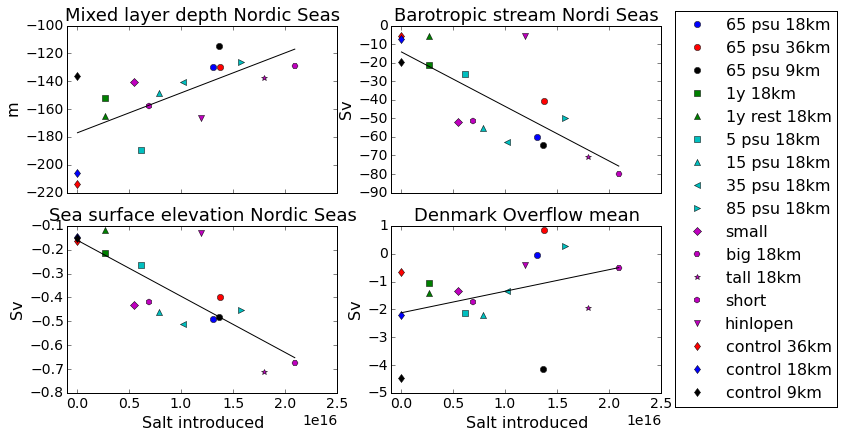

In [617]:
def salt_q_plot(dic,variables):
    fig , axes = plt.subplots(2,2,sharey=False,sharex=True)  
    var_ls_arr = {}
    for var in variables:
        var_ls_arr[var] = []
    for el in ["65 psu 18km" , "65 psu 36km",  "65 psu 9km" ,"1y 18km", "1y rest 18km" ,
            "5 psu 18km" , "15 psu 18km", "35 psu 18km","85 psu 18km","small", "big 18km", 'tall 18km', 
            "short", 'hinlopen','control 36km','control 18km','control 9km']:
        ax_ind = 0
        for var in variables:
            axes.flat[ax_ind].plot(dic[el].salt_amount,dic[el].comp_data[var],pert_style[el],label=el)
            ax = axes.flat[ax_ind].get_xaxis()
            axes.flat[ax_ind].set_title(var_titles[var],fontsize=18)
            if var[0:4] == 'mxld':
                axes.flat[ax_ind].set_ylabel('m',fontsize=16)
            else:
                axes.flat[ax_ind].set_ylabel('Sv',fontsize=16)
            var_ls_arr[var].append([dic[el].salt_amount,dic[el].comp_data[var]])
            plt.xlim(-0.1*1e16,2.5*1e16)
            ax_ind += 1
    axes.flat[2].set_xlabel('Salt introduced',fontsize=16)
    axes.flat[3].set_xlabel('Salt introduced',fontsize=16)
    ax_ind = 0
    for var in variables:
        arr = np.array(var_ls_arr[var])
        axes.flat[ax_ind].plot(np.unique(arr[:,0]),np.poly1d(np.polyfit(arr[:,0],arr[:,1],1))(np.unique(arr[:,0])),'k')
        ax_ind += 1
    
    plt.legend(bbox_to_anchor=(1.05,1.1), loc=6, borderaxespad=0.,fontsize=16,numpoints=1)    
    fig.subplots_adjust(right=1.5,top=1.4)
    fig.savefig('/noc/users/am8e13/Figures/mpert_sensitivity',dpi=dpires, bbox_inches='tight')

#var_arr = ['Fram_flux_mean','Fram_fwflux_mean','mxld_mean','Denmark_flux_mean','Denmark_fwflux_mean',\
#          'psi_mean','Denmark_overflow_mean','Denmark_overflow_min','Denmark_overflow_max']
var_arr = ['mxld_mean_nordseas','psi_mean_nordseas','eta_mean_nordseas','Denmark_overflow_mean' ]
           #'mxld_mean_global','psi_mean_global','eta_mean_global',\
           #'mxld_mean_arctic','psi_mean_arctic','eta_mean_arctic',]
#           'Denmark_overflow_mean']
salt_q_plot(pert_dic,var_arr)


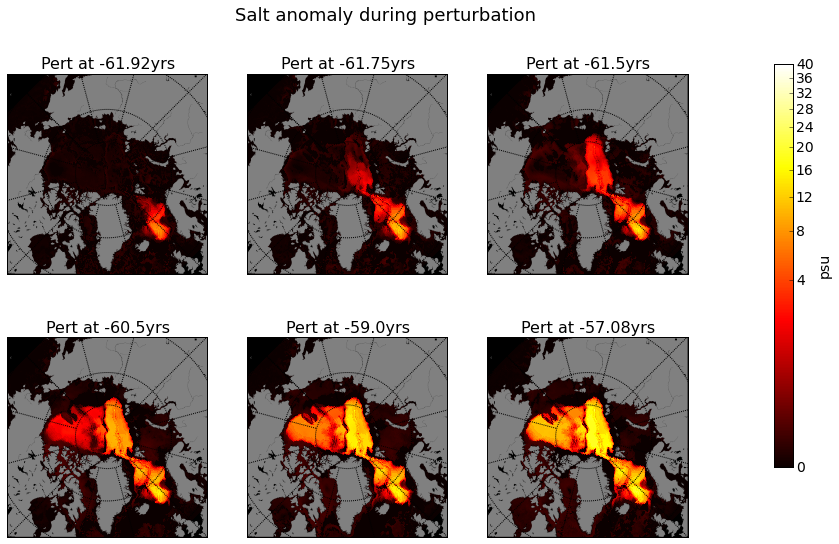

In [636]:
times = [1+12*5, 3+12*5, 6+12*5, 18+12*5,36+12*5,59+12*5]

def basemap_perturbation(data_pert,data_diff,times):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;sgn=1
    width=7000000. ; height=7000000.0
    ind = 0
    vimin = 0 ; vimax = 40
    fig, axes = plt.subplots(2,3)
            
    depth = np.tile([grid['Zp']],(len(data_pert.X),len(data_pert.Y),1))
    depth = np.swapaxes(depth,0,2) 
    for t in times:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='black')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='black')
        x,y=m(data_pert.lon,data_pert.lat)
        
        data = np.array(data_pert.data['S'][t,:,:,:])
        data1 = np.array(data_diff.data['S'][t,:,:,:])    
        datam = np.nansum(data*depth,axis=0)/np.abs(data_pert.Z[49]) - \
                np.nansum(data1*depth,axis=0)/np.abs(data_pert.Z[49])
        
        sitm = np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=matplotlib.cm.hot,vmin=vimin,vmax=vimax,\
                        norm=matplotlib.colors.PowerNorm(gamma=1./3.))
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title('Pert at '+str(round(data_pert.years[t]-5,2))+'yrs',fontsize=16)
        ind += 1
    fig.suptitle("Salt anomaly during perturbation",x=1.,y=2.,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'psu',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels([0,1,2,5,10,20,40])
    fig.subplots_adjust(right=1.7,top=1.8)    
    #fig.savefig('/noc/users/am8e13/Figures/perturbation_anom',dpi=dpires, bbox_inches='tight')
    
basemap_perturbation(pert_tall_18,pert_bench_18,times)

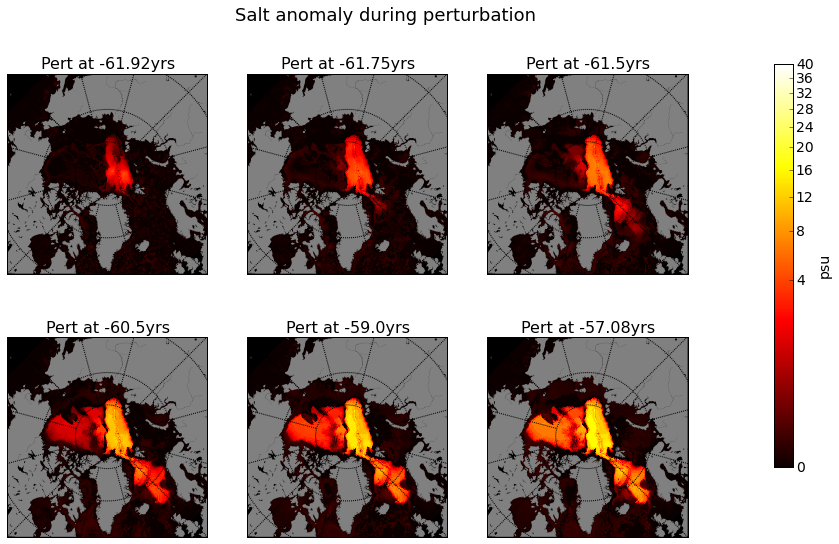

In [637]:
basemap_perturbation(pert_hinlop_18,pert_bench_18,times)

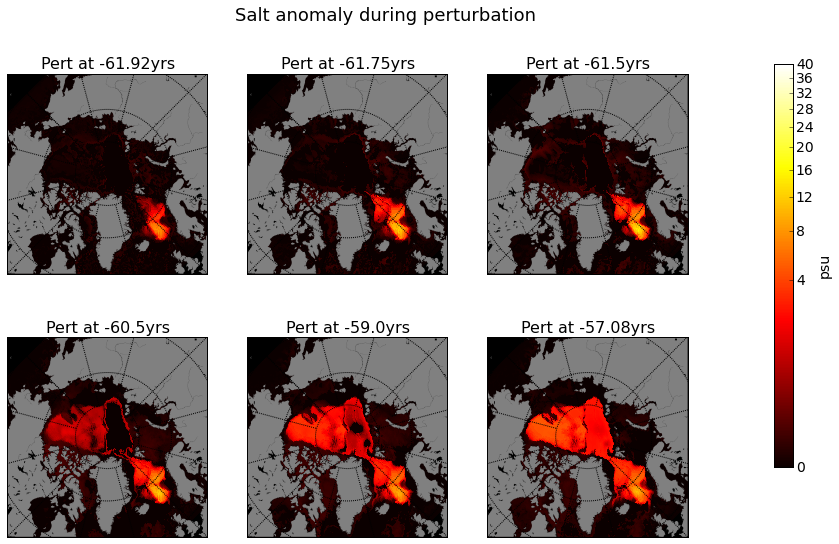

In [639]:
basemap_perturbation(pert_tall_18,pert_hinlop_18,times)